# Assessment Task 2: Data Analysis Project

**Subject:** 36103 Statistical Thinking for Data Science  
**Group:** #3

## Project Description

This project aims to reduce credit card default risk by designing new credit policies based on predictive modeling. Using the [UCI Credit Card dataset](https://raw.githubusercontent.com/Nelkit/36103-AT2-data-analysis-project/refs/heads/main/UCI_Credit_Card.csv), we developed Logistic Regression and Decision Tree models to identify high-risk customers and estimate potential credit losses. In addition, we applied statistical tests to explore significant differences between defaulters and non-defaulters. The objective is to support data-driven decision-making and strengthen credit risk management.

## Notebook Structure

This notebook is organized into the following sections:

0. Setup Environment  
1. Project Overview  
2. Data Loading  
3. Exploratory Data Analysis (EDA)  
4. Feature Selection  
5. Data Preprocessing  
6. Data Splitting  
7. Data Modeling  
8. Statistical Testing  
9. Insights and Conclusions

## 📝 TODO List

✅ Project Overview  
- [x] ~~1.1 Project Description~~  
- [x] ~~1.2 Business Objective~~  
- [x] ~~1.3 Research Questions~~  

📥 Data Loading and Understanding  
- [x] ~~Load the dataset~~  
- [x] ~~Check for missing values and duplicates~~  
- [x] ~~Understand data types and structure~~  

📊 Exploratory Data Analysis (EDA)  
- [x] ~~3.1 Data Understanding~~
- [x] ~~3.2 Explore features~~
- [x] ~~3.3 Explore target variable~~
- [x] ~~3.4 Explore relationships between target and predictors~~

🎯 Feature Selection  
- [x] ~~4.1 Feature Selection Approach (correlation, importance scores, etc.)~~  
- [x] ~~4.2 Final Selected Features~~

🛠 Data Preprocessing  
- [x] ~~5.1 Data Cleaning (handle missing values, outliers, duplicates)~~  
- [x] ~~5.2 Feature Engineering (create new features, transformations)~~  
- [x] ~~5.3 Data Transformation (scaling, encoding, normalization)~~  

🛠 Split the dataset
- [x] ~~6.1 Split the dataset~~
- [x] ~~6.2 Save the dataset~~

🤖 Data Modeling  
- [x] ~~7.1 Generate Predictions with Baseline Model~~
- [x] ~~7.2 Assess the Baseline Model~~
- [x] ~~7.3 Generate models (Decision Tree, Logistic Regression, Random Forest)~~
- [x] ~~7.4 Models insights~~
- [x] ~~7.5 Credit loss calculation~~
- [x] ~~7.6 Extract policy rules from the tree model~~
- [x] ~~7.7 Analyze feature importance and coefficients~~

📊 Statistical Testing
- [x] ~~8.0 Mann-Whitney U test~~
- [x] ~~8.1 Mann-Whitney insights~~

🔍 Insights and Conclusions  
- [ ] **9.1 Summarize key findings**  
- [ ] **9.2 Discuss model performance and business impact**  
- [ ] **9.3 Answer research questions**
- [ ] **9.4 Identify limitations and potential improvements**


## 0. Setup Environment

### 0.a Install Mandatory Packages

> Do not modify this code before running it

In [1]:
# Do not modify this code
!pip install -q utstd

from utstd.folders import *
from utstd.ipyrenders import *

at = AtFolder(
    course_code=36103,
    assignment="AT2",
)
at.run()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.7 MB/s eta 0:00:00
Mounted at /content/gdrive

You can now save your data files in: /content/gdrive/MyDrive/36103/assignment/AT2/data


### 0.b Disable Warnings Messages

> Do not modify this code before running it

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### 0.c Install Additional Packages

> If you are using additional packages, you need to install them here using the command: `! pip install <package_name>`

In [3]:
!pip install scipy

### 0.d Import Packages

In [50]:
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.gridspec as gridspec
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, recall_score, f1_score, roc_auc_score, precision_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.tree import plot_tree

### 0.f Reusable Functions

In [5]:
def plotting_num_feature_distributions(data, col, color = '#F9B123', dataset_name="", width=10, height=4):
  col_name = col.capitalize()
  # 1. Summary Statistics
  summary_stats = data[col].describe()
  print(f"Summary Statistics of {col_name} in {dataset_name}:")
  print(summary_stats)

  fig = plt.figure(figsize=(width, height))
  gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 4])

  # 2. Boxplot and Histogram plot
  ax_box = plt.subplot(gs[0, 0])
  sns.boxplot(x=data[col], ax=ax_box, color=color)
  ax_box.set(title=f'Boxplot and Histogram of {col_name} in {dataset_name}')
  ax_box.set(xlabel='')
  ax_box.set_xticklabels([])

  ax_hist = plt.subplot(gs[1, 0])
  sns.histplot(data, x=col, ax=ax_hist, color=color, bins=30, kde=False)
  ax_box.set_xlim(ax_hist.get_xlim())

  # 3. QQ plot
  ax_qq = plt.subplot(gs[:, 1])
  stats.probplot(data[col], dist="norm", plot=ax_qq)
  ax_qq.set_title(f'QQ Plot of {col_name} in {dataset_name}')

  plt.tight_layout()
  plt.show()

def plotting_cat_feature_distributions(data, col, dataset_name = ""):
  col_name = col.capitalize()
  print(f"Summary Statistics of {col_name} in {dataset_name}:")
  summary_stats = data[col].describe()
  print(summary_stats)

  target_count = data[col].value_counts()
  sizes = target_count.values
  total_records = len(data[col])
  category_order = target_count.index

  plt.figure(figsize=(8, 5))
  sns.countplot(data=data, x=col, hue=col, palette="Set1", order=category_order)
  plt.title(f"Distribution of {col_name} in {dataset_name}")
  for s, value in enumerate(sizes):
      percentage = (value / total_records) * 100
      percentage = round(percentage, 2)
      plt.text(s, value, f'{value} \n ({percentage}%)', color="#333", ha='center', va='bottom', fontsize=10, weight="bold")

  plt.xlabel(col_name)
  plt.ylabel("Count")
  plt.xticks(rotation=45, ha='right')
  plt.show()

def get_corr_of_predictors(method, data, predictors_names, width=6, height=5):
  continuous_data = data[predictors_names]

  correlation_matrix = continuous_data.corr(method=method)
  plt.figure(figsize=(width, height))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
  plt.title(f'Correlation Matrix of Predictors using {method.capitalize()} method')
  plt.show()

  return correlation_matrix

def check_duplicates(data):
    duplicates = data.duplicated()
    duplicates_count = duplicates.sum()
    total_records = len(data)
    percentage_duplicates = (duplicates_count / total_records) * 100
    percentage_duplicates = round(percentage_duplicates, 2)

    print(f'There are {duplicates_count} of {total_records} ({percentage_duplicates})% duplicates rows')
    return duplicates

def check_missing_values(data):
    missing_counts = data.isnull().sum()
    total_records = len(data)
    missing_summary = missing_counts[missing_counts > 0].sort_values(ascending=False)

    if missing_summary.empty:
        print("There are no missing values in the dataset.")
    else:
        print("Missing values per column:")
        for column, count in missing_summary.items():
            percentage = (count / total_records) * 100
            print(f"- {column}: {count} missing ({round(percentage, 2)}%)")

    return data.isnull()

def check_shape(data):
    rows, columns = data.shape
    print(f'The dataset has {rows} rows and {columns} columns.')
    return data.shape

def get_corr_of_predictors_and_target(method, data, target_name, predictors_names, width=6, height=3):
  continuous_data = data[predictors_names ]

  correlation_matrix = continuous_data.corr(method=method)
  ly_corr = correlation_matrix[target_name].sort_values(ascending=False)
  plt.figure(figsize=(width, height))
  sns.barplot(x=ly_corr.index, y=ly_corr.values, palette='coolwarm', hue=ly_corr.values)
  plt.title(f'Correlation of {target_name} with other attributes using {method.capitalize()} method')
  plt.xlabel('Attributes')
  plt.ylabel('Correlation Coefficient')

  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()

  plt.show()
  return correlation_matrix

def plotting_target_and_predictors(data, col, target, palette='pastel'):
  print(f"{col.capitalize()} Summary")
  print(data.groupby(col)[target].value_counts(normalize=True))

  plt.figure(figsize=(8, 5))
  sns.countplot(data=data, x=col, hue=target, palette=palette)
  plt.title(f"Relationship between {target} and {col}")
  plt.xlabel(f"{col}")
  plt.ylabel("Customer Count")
  plt.xticks(rotation=45, ha='right')
  plt.show()
  print("\n")

def plotting_target_and_num_predictors(data, col, target, palette='pastel'):
  print(f"{col.capitalize()} Summary")
  print(data.groupby(target)[col].describe())

  plt.figure(figsize=(6, 4))
  sns.boxplot(x=target, y=col, data=data, hue=target, palette=palette)
  plt.title(f'Distribution of {col} vs {target} variable')
  plt.show()

  print("\n")



## 1. Project Overview

### 1.1 Project Description

This project aims to reduce credit card default risk by designing new credit policies based on predictive modeling. Using the UCI Credit Card dataset, we developed Logistic Regression and Decision Tree models to identify high-risk customers and estimate potential credit losses. In addition, we applied statistical tests to explore significant differences between defaulters and non-defaulters. The objective is to support data-driven decision-making and strengthen credit risk management.


### 1.2 Business Objective

The business objective of this project is to:
- Reduce the number of customer defaults by using predictive models to inform policy decisions
- Evaluate and compare the effectiveness of Decision Tree, Random Forest, Logistic Regression models
- Identify whether credit limit (LIMIT_BAL) is a statistically significant differentiator between defaulters and non-defaulters
- Quantify potential credit losses under different policy scenarios
- Develop a new credit policy based on risk estimation

### 1.3 Research Questions

1. "Is there a statistically significant difference in credit limits between customers who default and those who do not?"
2. "How much can we reduce expected credit losses by implementing a model-based credit policy?"
3. "Which model (Decision Tree, Random Forest, Logistic Regression) provides the most effective and interpretable results for credit risk management?"

## 2. Data Loading

In [6]:
original_df = pd.read_csv(at.folder_path / "UCI_Credit_Card.csv")

## 3. Exploratory Data Analysis (EDA)

### 3.1 Data Understanding

In [7]:
original_df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month  
0       0.0       0.0       0.0                           1  
1    1000.0       0.0    2000.0                           1  
2    1000.0    1000.0    5000.0                           0  
3    1100.0    1069.0    1000.0                           0  
4    9000.0     689.0     679.0                           0  

[5 rows x 25 columns]

In [8]:
original_df.tail()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
29995  29996   220000.0    1          3         1   39      0      0      0   
29996  29997   150000.0    1          3         2   43     -1     -1     -1   
29997  29998    30000.0    1          2         2   37      4      3      2   
29998  29999    80000.0    1          3         1   41      1     -1      0   
29999  30000    50000.0    1          2         1   46      0      0      0   

       PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
29995      0  ...    88004.0    31237.0    15980.0    8500.0   20000.0   
29996     -1  ...     8979.0     5190.0        0.0    1837.0    3526.0   
29997     -1  ...    20878.0    20582.0    19357.0       0.0       0.0   
29998      0  ...    52774.0    11855.0    48944.0   85900.0    3409.0   
29999      0  ...    36535.0    32428.0    15313.0    2078.0    1800.0   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month  
29995    5003.0    3047.0    5000.0    1000.0                           0  
29996    8998.0     129.0       0.0       0.0                           0  
29997   22000.0    4200.0    2000.0    3100.0                           1  
29998    1178.0    1926.0   52964.0    1804.0                           1  
29999    1430.0    1000.0    1000.0    1000.0                           1  

[5 rows x 25 columns]

In [9]:
check_shape(original_df)

The dataset has 30000 rows and 25 columns.


(30000, 25)

In [10]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [11]:
original_df.describe()

ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853133      1.551867   
std     8660.398374   129747.661567      0.489129      0.790349      0.521970   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

                AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std        9.217904      1.123802      1.197186      1.196868      1.169139   
min       21.000000     -2.000000     -2.000000     -2.000000     -2.000000   
25%       28.000000     -1.000000     -1.000000     -1.000000     -1.000000   
50%       34.000000      0.000000      0.000000      0.000000      0.000000   
75%       41.000000      0.000000      0.000000      0.000000      0.000000   
max       79.000000      8.000000      8.000000      8.000000      8.000000   

       ...      BILL_AMT4      BILL_AMT5      BILL_AMT6       PAY_AMT1  \
count  ...   30000.000000   30000.000000   30000.000000   30000.000000   
mean   ...   43262.948967   40311.400967   38871.760400    5663.580500   
std    ...   64332.856134   60797.155770   59554.107537   16563.280354   
min    ... -170000.000000  -81334.000000 -339603.000000       0.000000   
25%    ...    2326.750000    1763.000000    1256.000000    1000.000000   
50%    ...   19052.000000   18104.500000   17071.000000    2100.000000   
75%    ...   54506.000000   50190.500000   49198.250000    5006.000000   
max    ...  891586.000000  927171.000000  961664.000000  873552.000000   

           PAY_AMT2      PAY_AMT3       PAY_AMT4       PAY_AMT5  \
count  3.000000e+04   30000.00000   30000.000000   30000.000000   
mean   5.921163e+03    5225.68150    4826.076867    4799.387633   
std    2.304087e+04   17606.96147   15666.159744   15278.305679   
min    0.000000e+00       0.00000       0.000000       0.000000   
25%    8.330000e+02     390.00000     296.000000     252.500000   
50%    2.009000e+03    1800.00000    1500.000000    1500.000000   
75%    5.000000e+03    4505.00000    4013.250000    4031.500000   
max    1.684259e+06  896040.00000  621000.000000  426529.000000   

            PAY_AMT6  default.payment.next.month  
count   30000.000000                30000.000000  
mean     5215.502567                    0.221200  
std     17777.465775                    0.415062  
min         0.000000                    0.000000  
25%       117.750000                    0.000000  
50%      1500.000000                    0.000000  
75%      4000.000000                    0.000000  
max    528666.000000                    1.000000  

[8 rows x 25 columns]

In [12]:
check_duplicates(original_df)

There are 0 of 30000 (0.0)% duplicates rows


0        False
1        False
2        False
3        False
4        False
         ...  
29995    False
29996    False
29997    False
29998    False
29999    False
Length: 30000, dtype: bool

In [13]:
check_missing_values(original_df)

There are no missing values in the dataset.


ID  LIMIT_BAL    SEX  EDUCATION  MARRIAGE    AGE  PAY_0  PAY_2  \
0      False      False  False      False     False  False  False  False   
1      False      False  False      False     False  False  False  False   
2      False      False  False      False     False  False  False  False   
3      False      False  False      False     False  False  False  False   
4      False      False  False      False     False  False  False  False   
...      ...        ...    ...        ...       ...    ...    ...    ...   
29995  False      False  False      False     False  False  False  False   
29996  False      False  False      False     False  False  False  False   
29997  False      False  False      False     False  False  False  False   
29998  False      False  False      False     False  False  False  False   
29999  False      False  False      False     False  False  False  False   

       PAY_3  PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
0      False  False  ...      False      False      False     False     False   
1      False  False  ...      False      False      False     False     False   
2      False  False  ...      False      False      False     False     False   
3      False  False  ...      False      False      False     False     False   
4      False  False  ...      False      False      False     False     False   
...      ...    ...  ...        ...        ...        ...       ...       ...   
29995  False  False  ...      False      False      False     False     False   
29996  False  False  ...      False      False      False     False     False   
29997  False  False  ...      False      False      False     False     False   
29998  False  False  ...      False      False      False     False     False   
29999  False  False  ...      False      False      False     False     False   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month  
0         False     False     False     False                       False  
1         False     False     False     False                       False  
2         False     False     False     False                       False  
3         False     False     False     False                       False  
4         False     False     False     False                       False  
...         ...       ...       ...       ...                         ...  
29995     False     False     False     False                       False  
29996     False     False     False     False                       False  
29997     False     False     False     False                       False  
29998     False     False     False     False                       False  
29999     False     False     False     False                       False  

[30000 rows x 25 columns]

> #### **Section 3.1 Insights**

- The dataset contains 30,000 rows and 25 columns.
- It includes 20 numerical and 4 categorical predictors.
- The target variable is `default.payment.next.month`.
- There are 0 duplicate rows out of 30,000 (0.0%).
- There are no missing values in the dataset.

### 3.2 Explore features

In [14]:
#Renaming columns
original_df.rename(columns={'PAY_0':'PAY_SEPT','PAY_2':'PAY_AUG','PAY_3':'PAY_JUL','PAY_4':'PAY_JUN','PAY_5':'PAY_MAY','PAY_6':'PAY_APR'},inplace=True)
original_df.rename(columns={'BILL_AMT1':'BILL_AMT_SEPT','BILL_AMT2':'BILL_AMT_AUG','BILL_AMT3':'BILL_AMT_JUL','BILL_AMT4':'BILL_AMT_JUN','BILL_AMT5':'BILL_AMT_MAY','BILL_AMT6':'BILL_AMT_APR'}, inplace = True)
original_df.rename(columns={'PAY_AMT1':'PAY_AMT_SEPT','PAY_AMT2':'PAY_AMT_AUG','PAY_AMT3':'PAY_AMT_JUL','PAY_AMT4':'PAY_AMT_JUN','PAY_AMT5':'PAY_AMT_MAY','PAY_AMT6':'PAY_AMT_APR'},inplace=True)
original_df.rename(columns={'default.payment.next.month':'PAYMENT_DEFAULT'},inplace=True)

# Get Categorical and Numerical Features
num_cols = list(original_df.select_dtypes(include=['int64', 'float64']).columns)
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
target_col = 'PAYMENT_DEFAULT'

# Remove categorical columns from num_cols
num_cols = [col for col in num_cols if col not in cat_cols + ['ID', target_col]]

print("Numerical columns:")
print(num_cols)
print("\nCategorical columns:")
print(cat_cols)
print("\nTarget column:")
print(target_col)

Numerical columns:
['LIMIT_BAL', 'AGE', 'PAY_SEPT', 'PAY_AUG', 'PAY_JUL', 'PAY_JUN', 'PAY_MAY', 'PAY_APR', 'BILL_AMT_SEPT', 'BILL_AMT_AUG', 'BILL_AMT_JUL', 'BILL_AMT_JUN', 'BILL_AMT_MAY', 'BILL_AMT_APR', 'PAY_AMT_SEPT', 'PAY_AMT_AUG', 'PAY_AMT_JUL', 'PAY_AMT_JUN', 'PAY_AMT_MAY', 'PAY_AMT_APR']

Categorical columns:
['SEX', 'EDUCATION', 'MARRIAGE']

Target column:
PAYMENT_DEFAULT


Summary Statistics of Limit_bal in Original set:
count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64


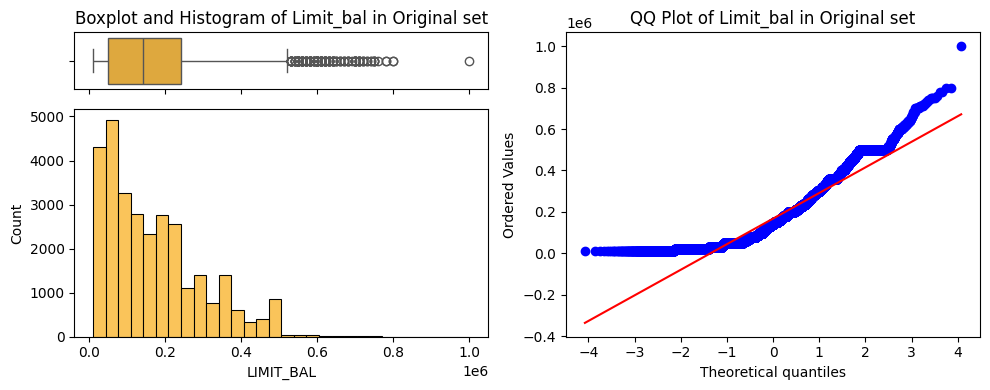

Summary Statistics of Age in Original set:
count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64


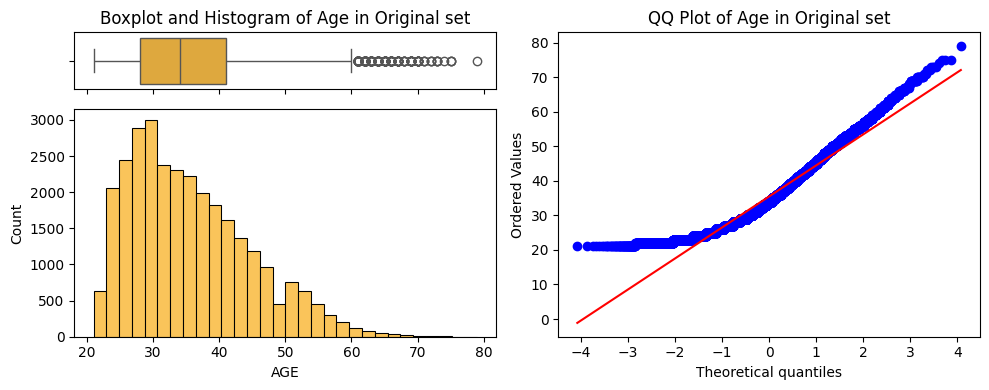

Summary Statistics of Pay_sept in Original set:
count    30000.000000
mean        -0.016700
std          1.123802
min         -2.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: PAY_SEPT, dtype: float64


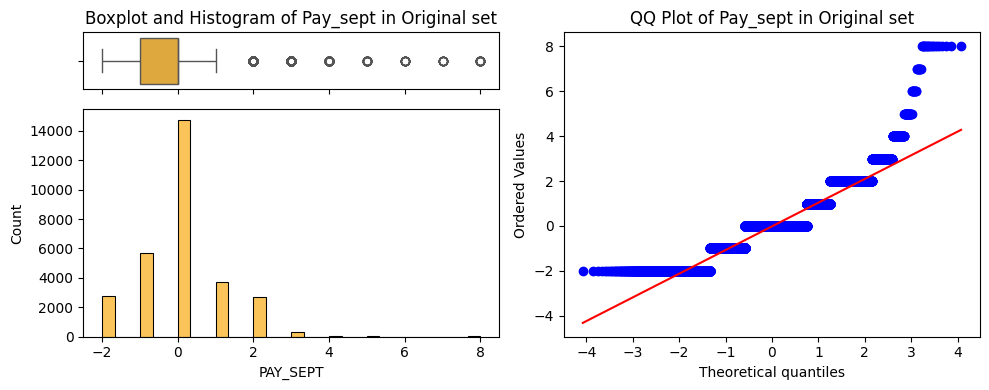

Summary Statistics of Pay_aug in Original set:
count    30000.000000
mean        -0.133767
std          1.197186
min         -2.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: PAY_AUG, dtype: float64


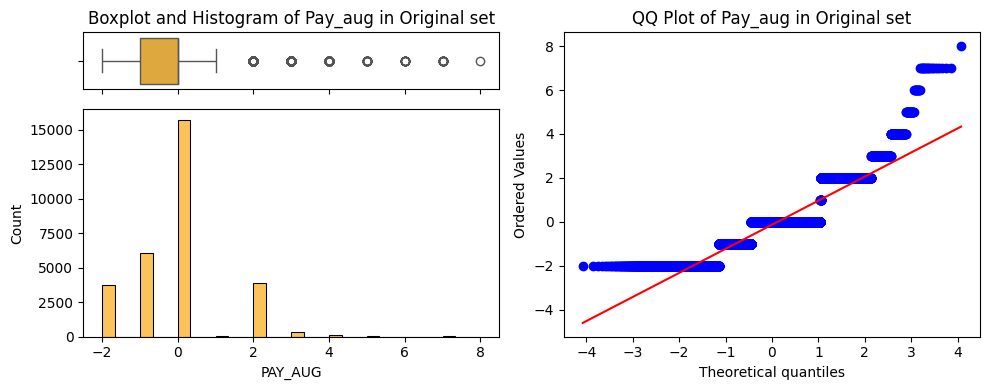

Summary Statistics of Pay_jul in Original set:
count    30000.000000
mean        -0.166200
std          1.196868
min         -2.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: PAY_JUL, dtype: float64


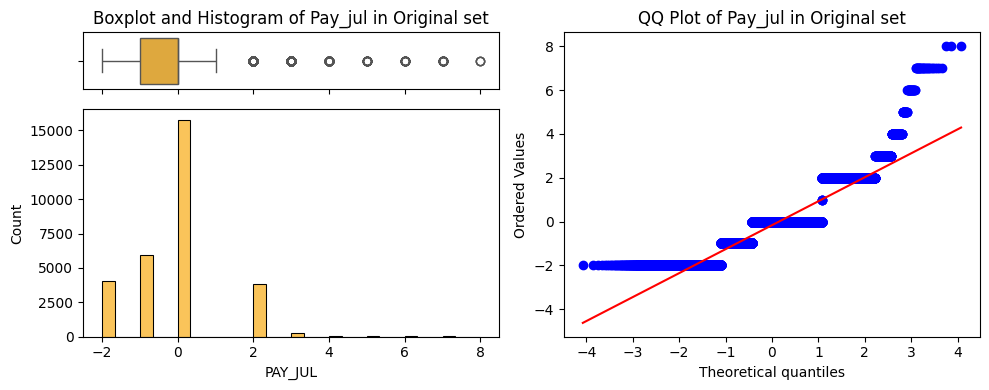

Summary Statistics of Pay_jun in Original set:
count    30000.000000
mean        -0.220667
std          1.169139
min         -2.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: PAY_JUN, dtype: float64


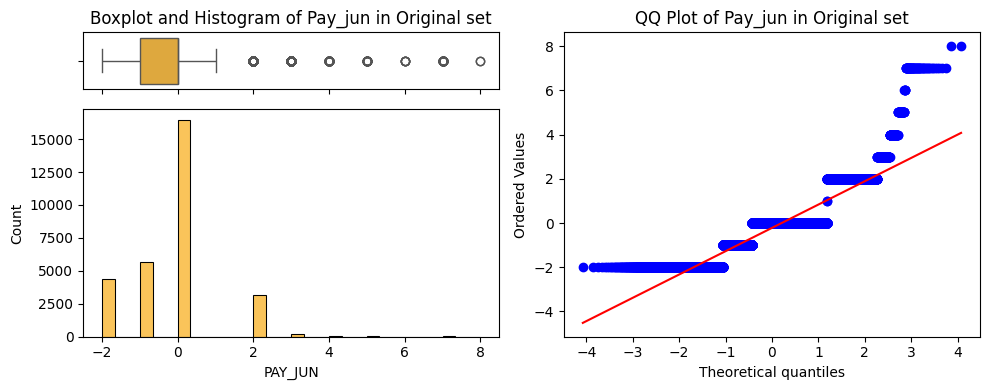

Summary Statistics of Pay_may in Original set:
count    30000.000000
mean        -0.266200
std          1.133187
min         -2.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: PAY_MAY, dtype: float64


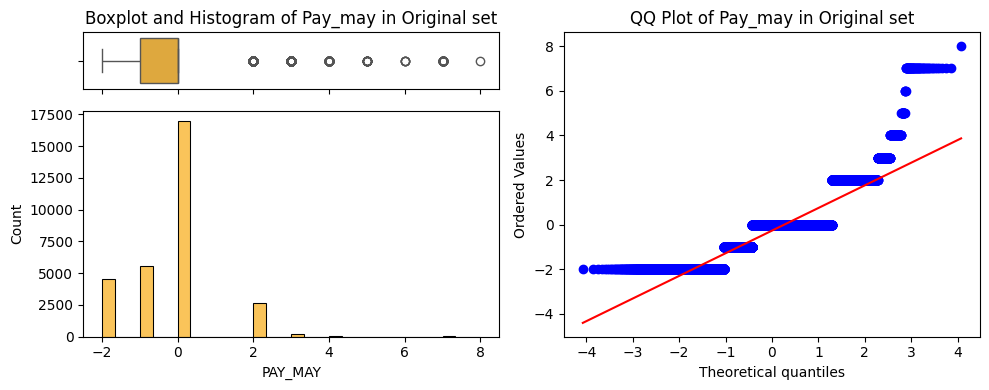

Summary Statistics of Pay_apr in Original set:
count    30000.000000
mean        -0.291100
std          1.149988
min         -2.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: PAY_APR, dtype: float64


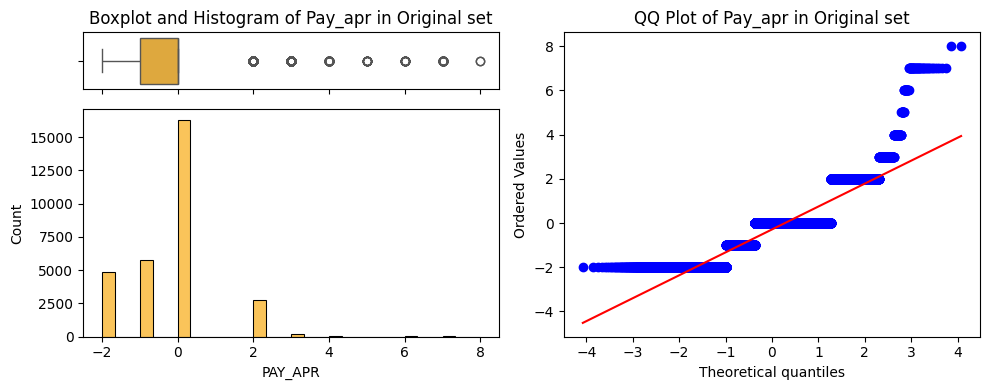

Summary Statistics of Bill_amt_sept in Original set:
count     30000.000000
mean      51223.330900
std       73635.860576
min     -165580.000000
25%        3558.750000
50%       22381.500000
75%       67091.000000
max      964511.000000
Name: BILL_AMT_SEPT, dtype: float64


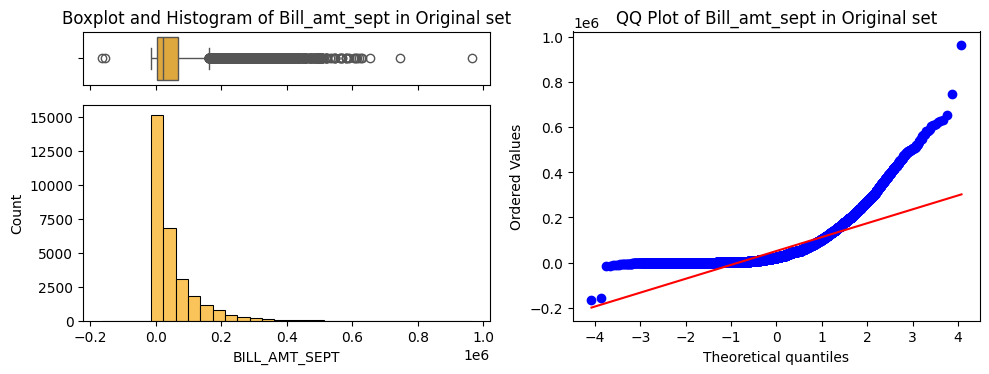

Summary Statistics of Bill_amt_aug in Original set:
count     30000.000000
mean      49179.075167
std       71173.768783
min      -69777.000000
25%        2984.750000
50%       21200.000000
75%       64006.250000
max      983931.000000
Name: BILL_AMT_AUG, dtype: float64


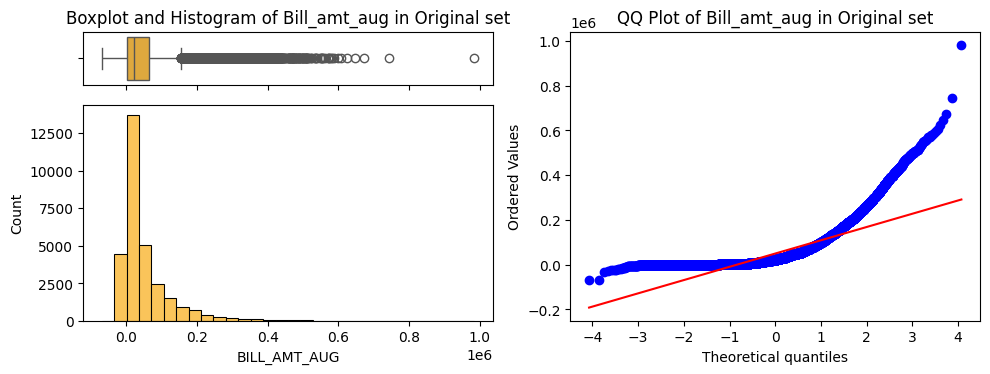

Summary Statistics of Bill_amt_jul in Original set:
count    3.000000e+04
mean     4.701315e+04
std      6.934939e+04
min     -1.572640e+05
25%      2.666250e+03
50%      2.008850e+04
75%      6.016475e+04
max      1.664089e+06
Name: BILL_AMT_JUL, dtype: float64


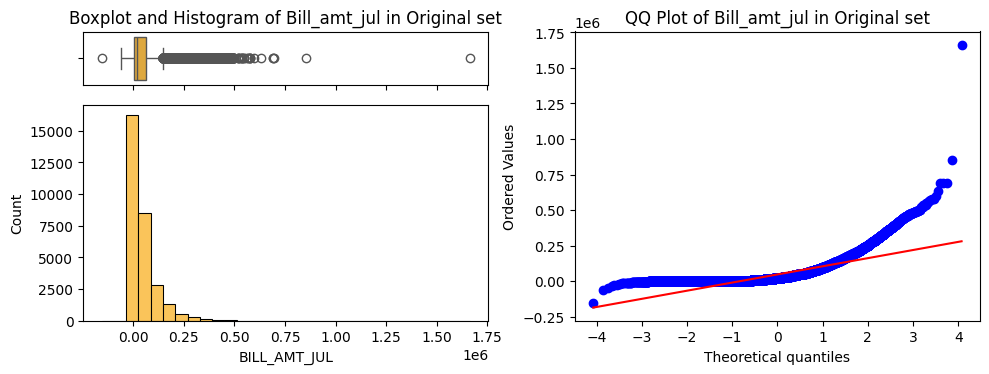

Summary Statistics of Bill_amt_jun in Original set:
count     30000.000000
mean      43262.948967
std       64332.856134
min     -170000.000000
25%        2326.750000
50%       19052.000000
75%       54506.000000
max      891586.000000
Name: BILL_AMT_JUN, dtype: float64


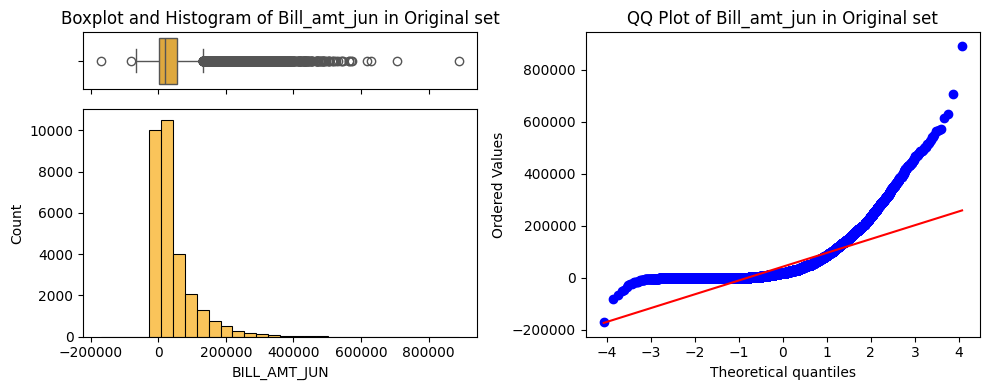

Summary Statistics of Bill_amt_may in Original set:
count     30000.000000
mean      40311.400967
std       60797.155770
min      -81334.000000
25%        1763.000000
50%       18104.500000
75%       50190.500000
max      927171.000000
Name: BILL_AMT_MAY, dtype: float64


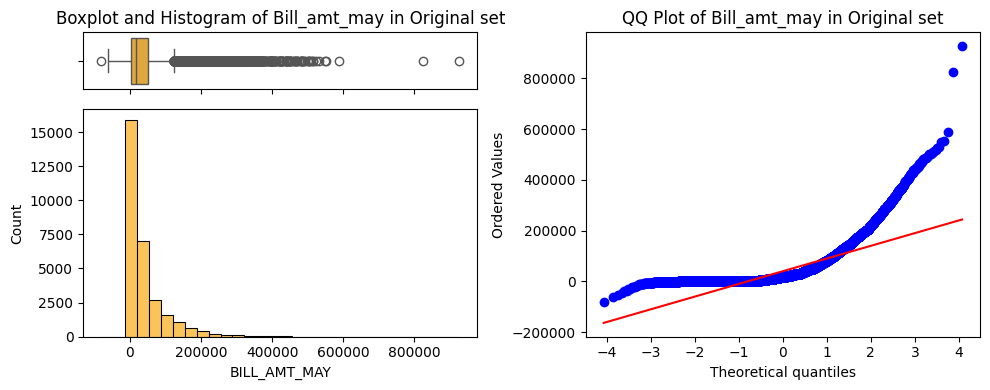

Summary Statistics of Bill_amt_apr in Original set:
count     30000.000000
mean      38871.760400
std       59554.107537
min     -339603.000000
25%        1256.000000
50%       17071.000000
75%       49198.250000
max      961664.000000
Name: BILL_AMT_APR, dtype: float64


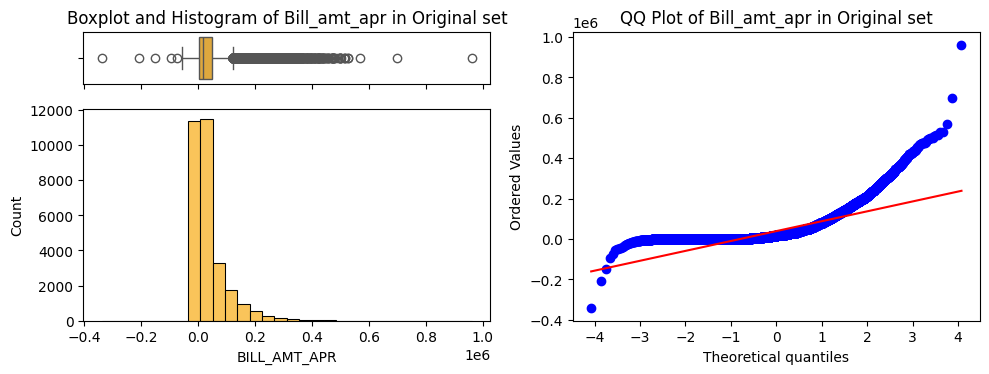

Summary Statistics of Pay_amt_sept in Original set:
count     30000.000000
mean       5663.580500
std       16563.280354
min           0.000000
25%        1000.000000
50%        2100.000000
75%        5006.000000
max      873552.000000
Name: PAY_AMT_SEPT, dtype: float64


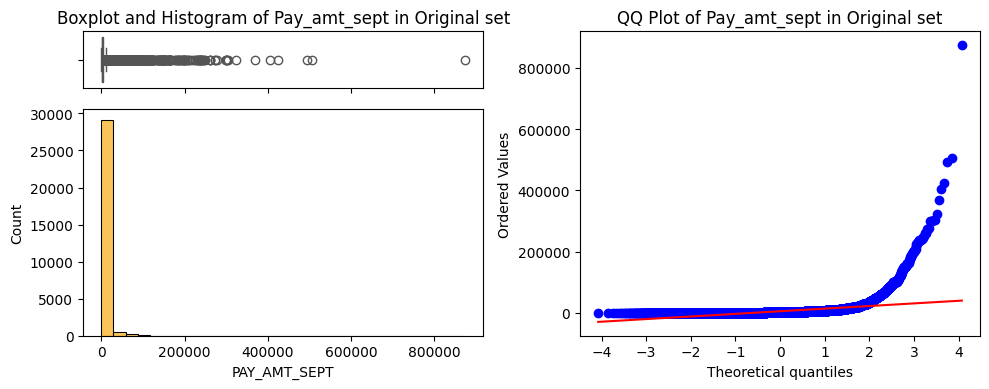

Summary Statistics of Pay_amt_aug in Original set:
count    3.000000e+04
mean     5.921163e+03
std      2.304087e+04
min      0.000000e+00
25%      8.330000e+02
50%      2.009000e+03
75%      5.000000e+03
max      1.684259e+06
Name: PAY_AMT_AUG, dtype: float64


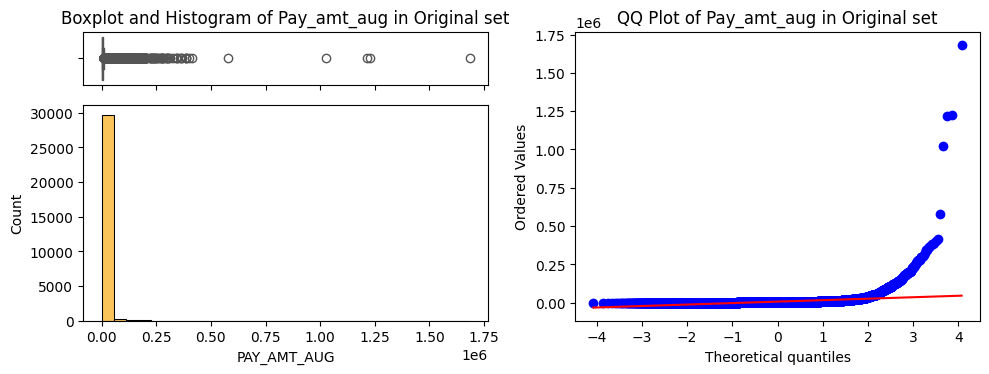

Summary Statistics of Pay_amt_jul in Original set:
count     30000.00000
mean       5225.68150
std       17606.96147
min           0.00000
25%         390.00000
50%        1800.00000
75%        4505.00000
max      896040.00000
Name: PAY_AMT_JUL, dtype: float64


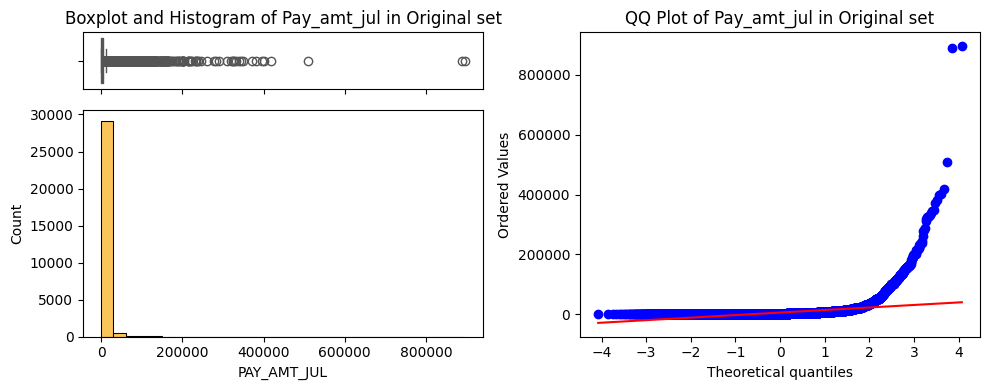

Summary Statistics of Pay_amt_jun in Original set:
count     30000.000000
mean       4826.076867
std       15666.159744
min           0.000000
25%         296.000000
50%        1500.000000
75%        4013.250000
max      621000.000000
Name: PAY_AMT_JUN, dtype: float64


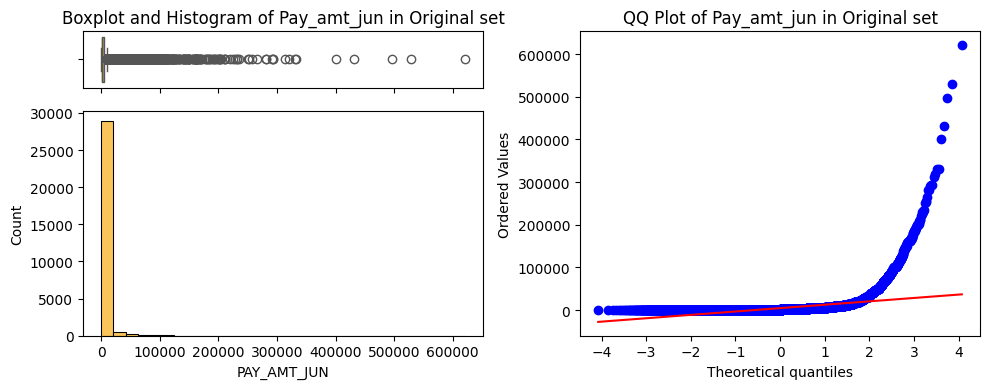

Summary Statistics of Pay_amt_may in Original set:
count     30000.000000
mean       4799.387633
std       15278.305679
min           0.000000
25%         252.500000
50%        1500.000000
75%        4031.500000
max      426529.000000
Name: PAY_AMT_MAY, dtype: float64


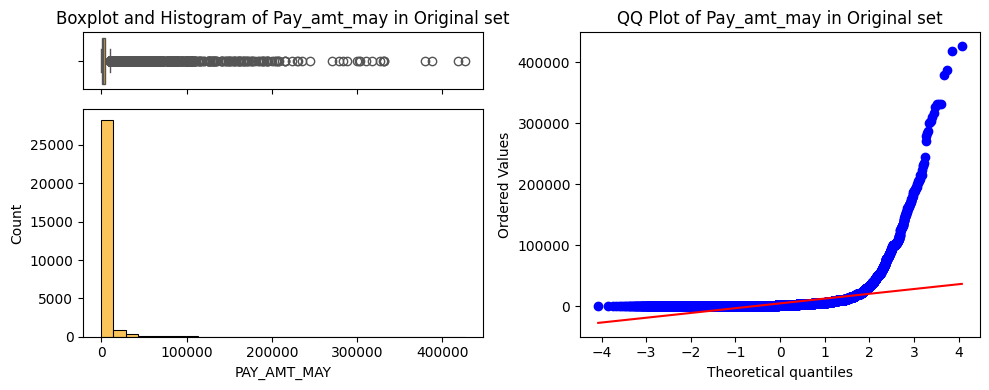

Summary Statistics of Pay_amt_apr in Original set:
count     30000.000000
mean       5215.502567
std       17777.465775
min           0.000000
25%         117.750000
50%        1500.000000
75%        4000.000000
max      528666.000000
Name: PAY_AMT_APR, dtype: float64


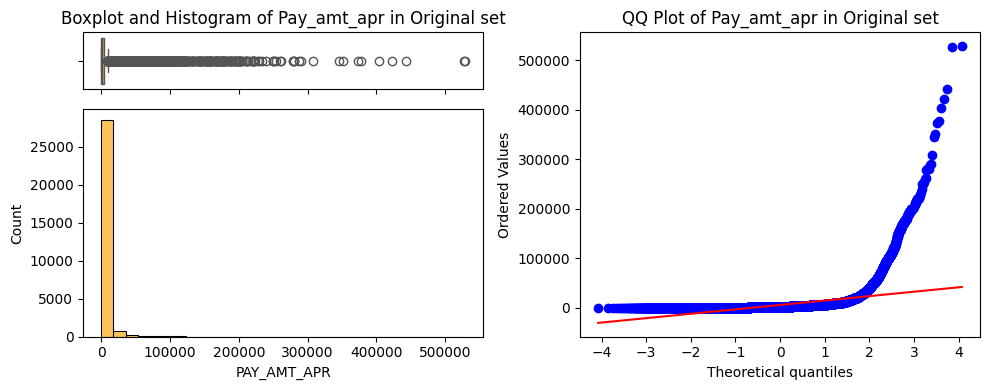

In [15]:
for col in num_cols:
  plotting_num_feature_distributions(original_df, col, dataset_name="Original set")

Summary Statistics of Sex in set:
count      30000
unique         2
top       female
freq       18112
Name: SEX, dtype: object


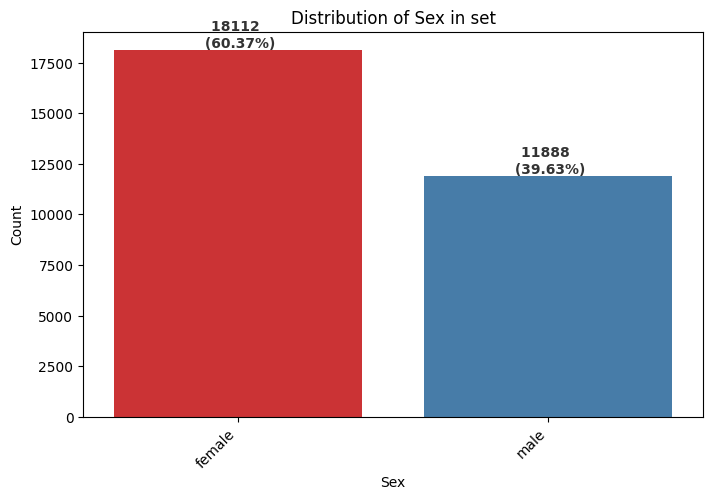

Summary Statistics of Education in set:
count          30000
unique             4
top       university
freq           14030
Name: EDUCATION, dtype: object


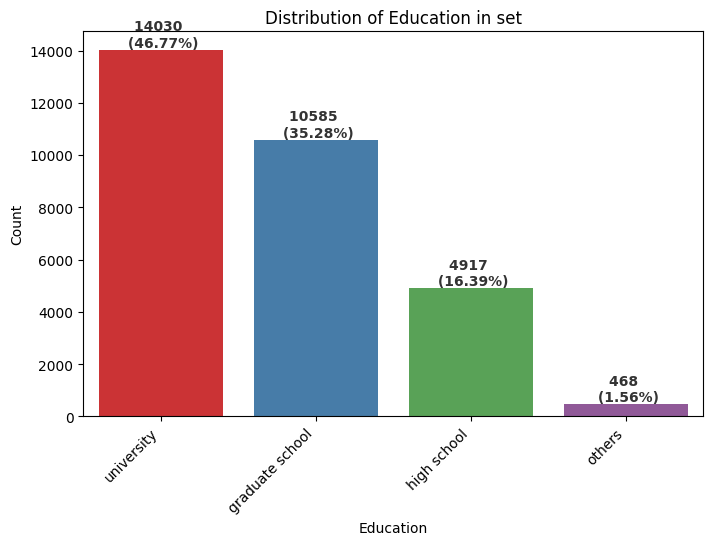

Summary Statistics of Marriage in set:
count      30000
unique         3
top       single
freq       15964
Name: MARRIAGE, dtype: object


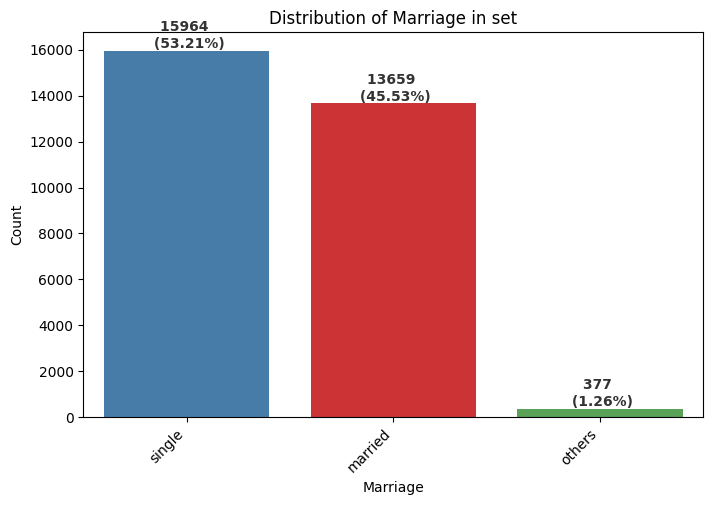

In [16]:
cat_df = original_df[cat_cols].copy()
cat_df[target_col] = original_df[target_col]

replace_dict = {
    'SEX': {1: 'male', 2: 'female'},
    'EDUCATION': {1: 'graduate school', 2: 'university', 3: 'high school'},
    'MARRIAGE': {1: 'married', 2: 'single'},
    'PAYMENT_DEFAULT': {0: 'no', 1: 'yes'}
}

for col in replace_dict:
    cat_df[col] = original_df[col].map(replace_dict[col]).fillna('others')

for col in cat_cols:
    plotting_cat_feature_distributions(cat_df, col, dataset_name="set")

> #### **Section 3.2 Insights**

- The numerical predictors include: `LIMIT_BAL`, `AGE`, `PAY_SEPT`, `PAY_AUG`, `PAY_JUL`, `PAY_JUN`, `PAY_MAY`, `PAY_APR`, `BILL_AMT_SEPT`, `BILL_AMT_AUG`, `BILL_AMT_JUL`, `BILL_AMT_JUN`, `BILL_AMT_MAY`, `BILL_AMT_APR`, `PAY_AMT_SEPT`, `PAY_AMT_AUG`, `PAY_AMT_JUL`, `PAY_AMT_JUN`, `PAY_AMT_MAY`, `PAY_AMT_APR`
- The categorical predictors are: `SEX`, `EDUCATION`, and `MARRIAGE`.
- The variables `LIMIT_BAL` and `AGE` are right-skewed and contain some outliers.
- The variables `BILL_AMT_APR` to `BILL_AMT_SEPT` and `PAY_AMT_APR` to `PAY_AMT_SEPT` are also right-skewed and exhibit many outliers.
- The dataset contains more observations for females than males according to the `SEX` variable, with 18,112 records for females and 11,888 for males.
- In `EDUCATION`, the most frequent category is university, with 14,030 records.
- For `MARRIAGE`, the most common category is single, with 15,964 records.

### 3.3 Explore target variable

Summary Statistics of Payment_default in Original set:
count     30000
unique        2
top          no
freq      23364
Name: PAYMENT_DEFAULT, dtype: object


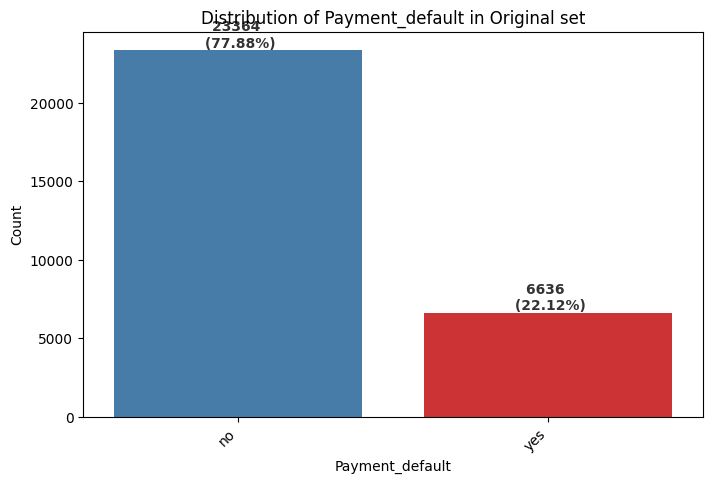

In [17]:
plotting_cat_feature_distributions(cat_df, target_col, dataset_name="Original set")

> #### **Section 3.3 Insights**

- The original target variable is `default.payment.next.month`, but it was renamed to `PAYMENT_DEFAULT` for easier handling.
- It is an imbalanced dataset, with 23,364 records (77.88%) labeled as no default and 6,636 records (22.12%) labeled as default.

### 3.4 Explore relationships between target and predictors

Sex Summary
SEX     PAYMENT_DEFAULT
female  no                 0.792237
        yes                0.207763
male    no                 0.758328
        yes                0.241672
Name: proportion, dtype: float64


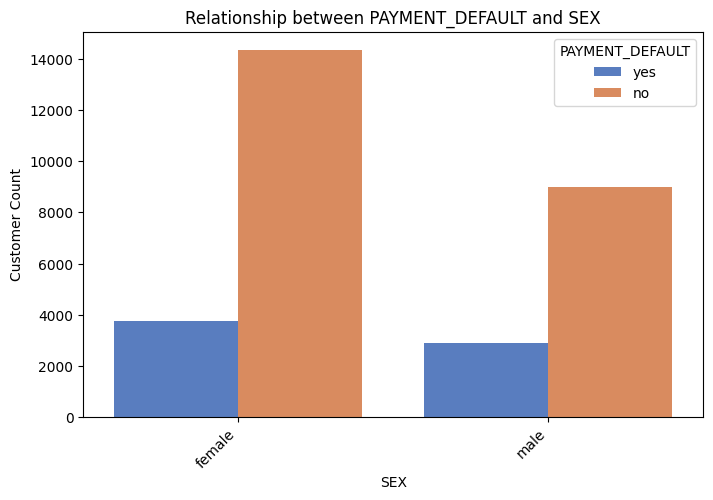



Education Summary
EDUCATION        PAYMENT_DEFAULT
graduate school  no                 0.807652
                 yes                0.192348
high school      no                 0.748424
                 yes                0.251576
others           no                 0.929487
                 yes                0.070513
university       no                 0.762651
                 yes                0.237349
Name: proportion, dtype: float64


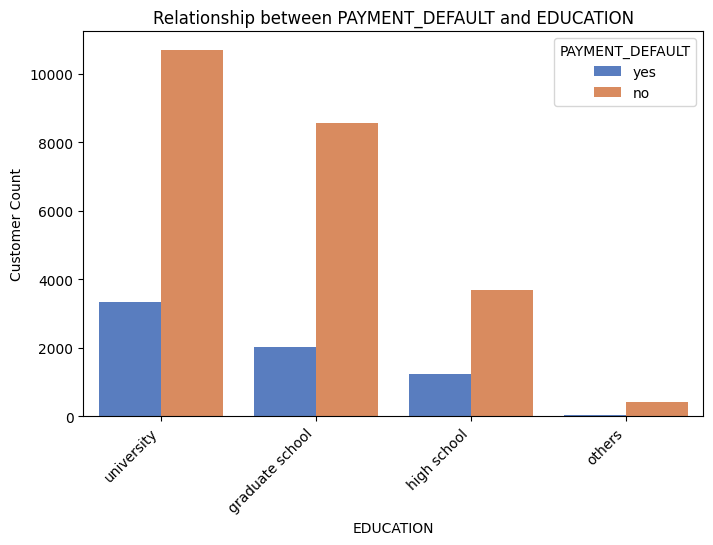



Marriage Summary
MARRIAGE  PAYMENT_DEFAULT
married   no                 0.765283
          yes                0.234717
others    no                 0.763926
          yes                0.236074
single    no                 0.790717
          yes                0.209283
Name: proportion, dtype: float64


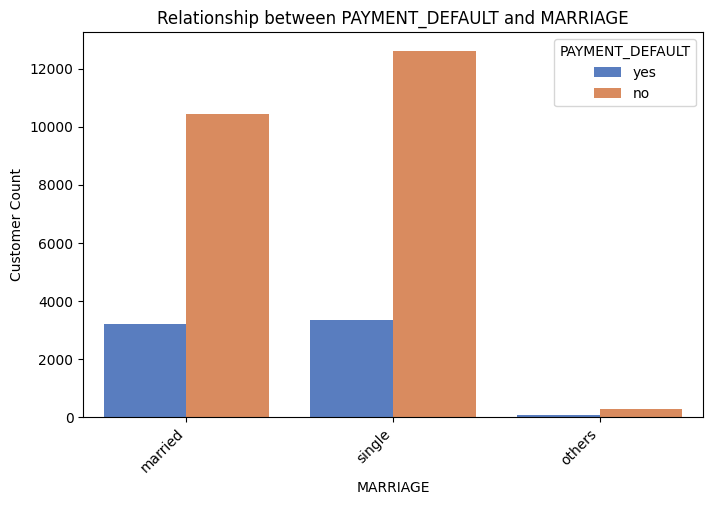

In [18]:
for col in cat_cols:
  plotting_target_and_predictors(cat_df, col, target_col, 'muted')

Limit_bal Summary
                   count           mean            std      min      25%  \
PAYMENT_DEFAULT                                                            
0                23364.0  178099.726074  131628.359660  10000.0  70000.0   
1                 6636.0  130109.656420  115378.540571  10000.0  50000.0   

                      50%       75%        max  
PAYMENT_DEFAULT                                 
0                150000.0  250000.0  1000000.0  
1                 90000.0  200000.0   740000.0  


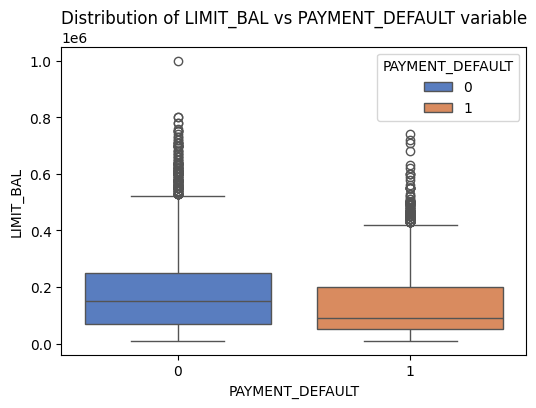



Age Summary
                   count       mean       std   min   25%   50%   75%   max
PAYMENT_DEFAULT                                                            
0                23364.0  35.417266  9.077355  21.0  28.0  34.0  41.0  79.0
1                 6636.0  35.725738  9.693438  21.0  28.0  34.0  42.0  75.0


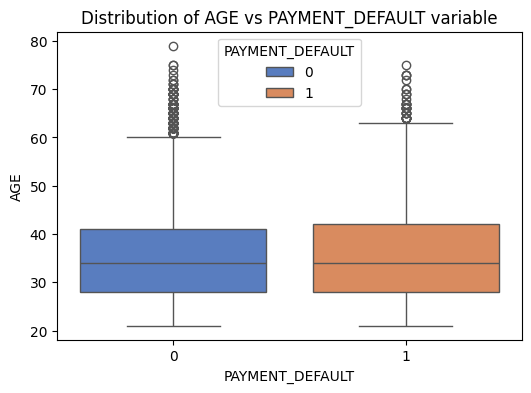



Pay_sept Summary
                   count      mean       std  min  25%  50%  75%  max
PAYMENT_DEFAULT                                                      
0                23364.0 -0.211222  0.952464 -2.0 -1.0  0.0  0.0  8.0
1                 6636.0  0.668174  1.383252 -2.0  0.0  1.0  2.0  8.0


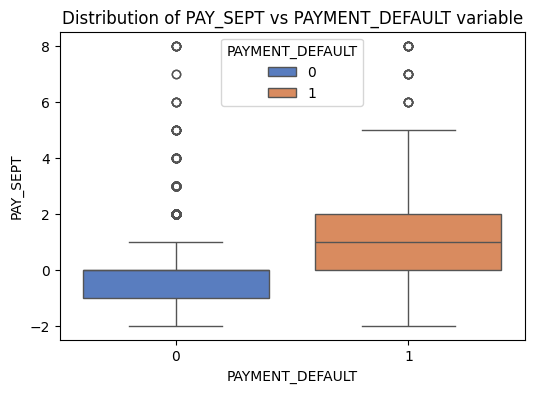



Pay_aug Summary
                   count      mean       std  min  25%  50%  75%  max
PAYMENT_DEFAULT                                                      
0                23364.0 -0.301917  1.035191 -2.0 -1.0  0.0  0.0  8.0
1                 6636.0  0.458258  1.502243 -2.0  0.0  0.0  2.0  7.0


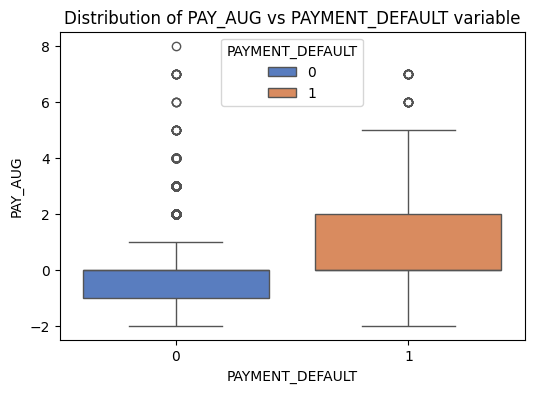



Pay_jul Summary
                   count      mean       std  min  25%  50%  75%  max
PAYMENT_DEFAULT                                                      
0                23364.0 -0.316256  1.048378 -2.0 -1.0  0.0  0.0  8.0
1                 6636.0  0.362116  1.499401 -2.0 -1.0  0.0  2.0  8.0


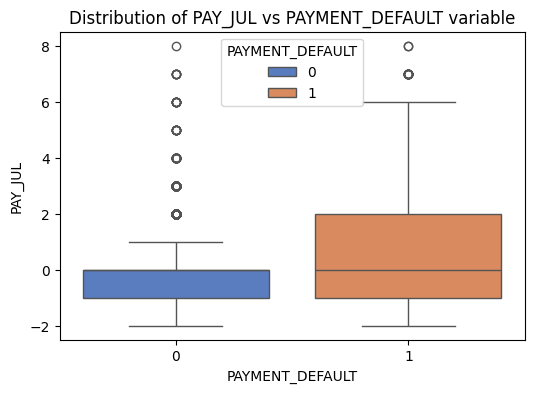



Pay_jun Summary
                   count      mean       std  min  25%  50%  75%  max
PAYMENT_DEFAULT                                                      
0                23364.0 -0.355633  1.013162 -2.0 -1.0  0.0  0.0  8.0
1                 6636.0  0.254521  1.508535 -2.0 -1.0  0.0  2.0  8.0


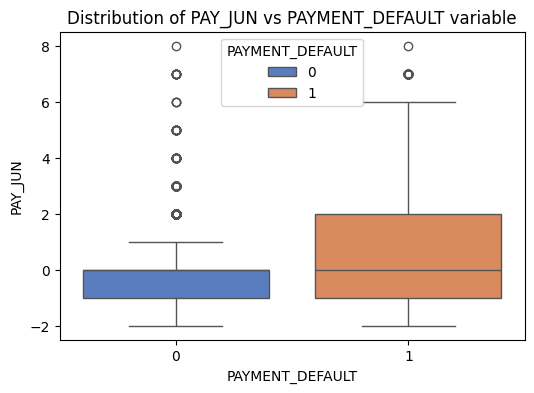



Pay_may Summary
                   count      mean       std  min  25%  50%  75%  max
PAYMENT_DEFAULT                                                      
0                23364.0 -0.389488  0.977591 -2.0 -1.0  0.0  0.0  7.0
1                 6636.0  0.167872  1.482833 -2.0 -1.0  0.0  0.0  8.0


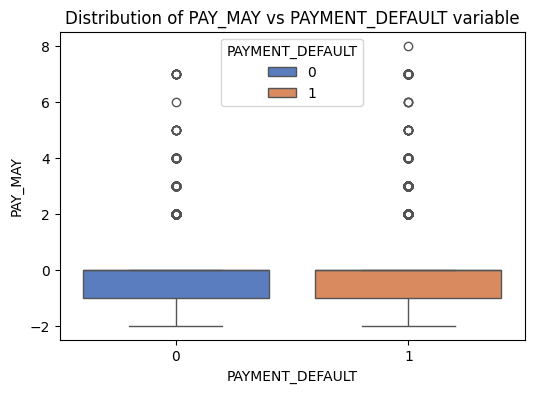



Pay_apr Summary
                   count      mean       std  min  25%  50%  75%  max
PAYMENT_DEFAULT                                                      
0                23364.0 -0.405624  1.005930 -2.0 -1.0  0.0  0.0  7.0
1                 6636.0  0.112116  1.485757 -2.0 -1.0  0.0  0.0  8.0


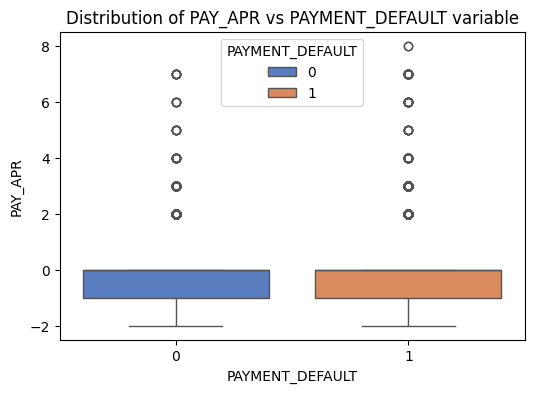



Bill_amt_sept Summary
                   count          mean           std       min      25%  \
PAYMENT_DEFAULT                                                           
0                23364.0  51994.227273  73577.606694 -165580.0  3677.25   
1                 6636.0  48509.162297  73782.067220   -6676.0  2987.75   

                     50%      75%       max  
PAYMENT_DEFAULT                              
0                23119.5  69027.0  964511.0  
1                20185.0  59626.5  613860.0  


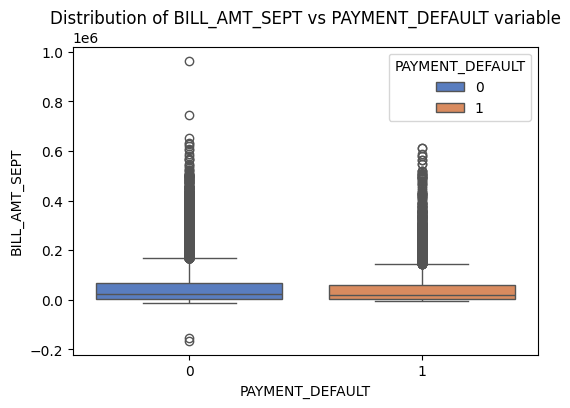



Bill_amt_aug Summary
                   count          mean           std      min     25%  \
PAYMENT_DEFAULT                                                         
0                23364.0  49717.435670  71029.946709 -69777.0  3055.0   
1                 6636.0  47283.617842  71651.030364 -17710.0  2694.0   

                     50%       75%       max  
PAYMENT_DEFAULT                               
0                21660.5  65686.00  983931.0  
1                20300.5  57919.75  581775.0  


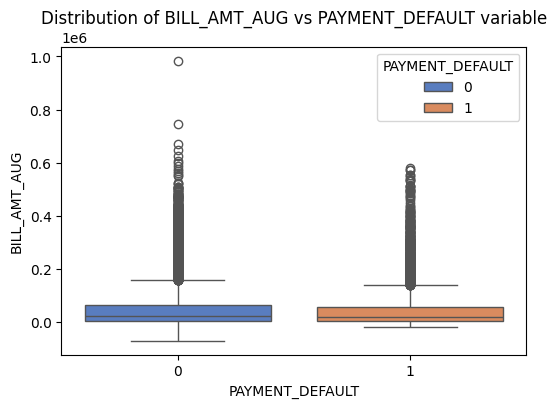



Bill_amt_jul Summary
                   count          mean           std       min      25%  \
PAYMENT_DEFAULT                                                           
0                23364.0  47533.365605  69576.661008 -157264.0  2769.75   
1                 6636.0  45181.598855  68516.975738  -61506.0  2500.00   

                     50%       75%        max  
PAYMENT_DEFAULT                                
0                20202.5  61894.00  1664089.0  
1                19834.5  54733.75   578971.0  


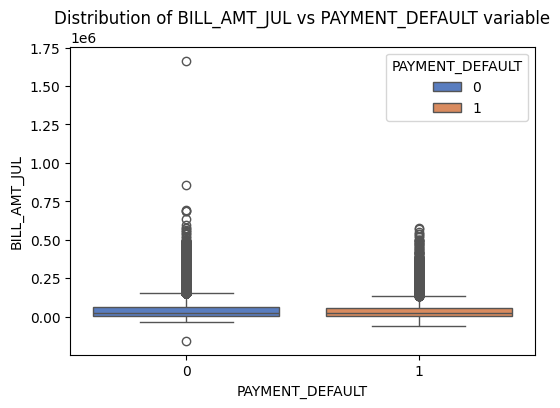



Bill_amt_jun Summary
                   count          mean           std       min     25%  \
PAYMENT_DEFAULT                                                          
0                23364.0  43611.165254  64324.796730 -170000.0  2360.0   
1                 6636.0  42036.950573  64351.076092  -65167.0  2141.5   

                     50%       75%       max  
PAYMENT_DEFAULT                               
0                19000.0  55988.00  891586.0  
1                19119.5  50175.75  548020.0  


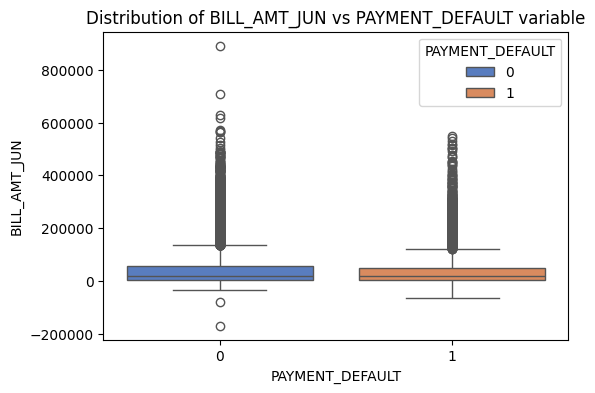



Bill_amt_may Summary
                   count          mean           std      min      25%  \
PAYMENT_DEFAULT                                                          
0                23364.0  40530.445343  60617.268112 -81334.0  1823.00   
1                 6636.0  39540.190476  61424.695949 -53007.0  1502.75   

                     50%       75%       max  
PAYMENT_DEFAULT                               
0                17998.0  51135.25  927171.0  
1                18478.5  47853.00  547880.0  


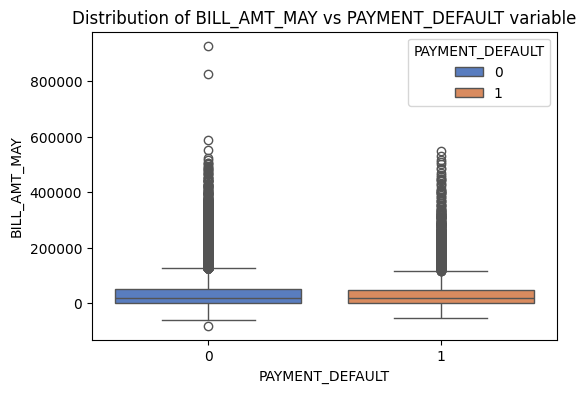



Bill_amt_apr Summary
                   count          mean           std       min     25%  \
PAYMENT_DEFAULT                                                          
0                23364.0  39042.268704  59547.015717 -209051.0  1265.5   
1                 6636.0  38271.435503  59579.674268 -339603.0  1150.0   

                     50%      75%       max  
PAYMENT_DEFAULT                              
0                16679.0  49842.5  961664.0  
1                18028.5  47424.0  514975.0  


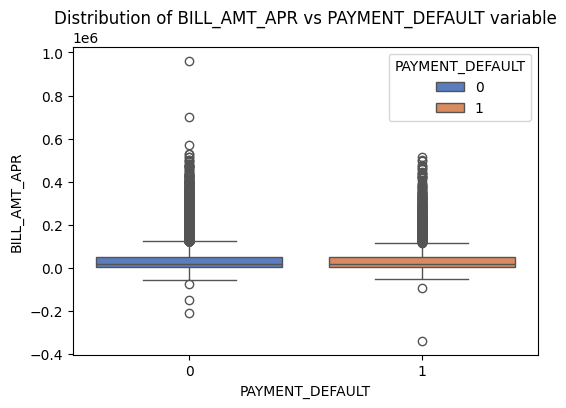



Pay_amt_sept Summary
                   count         mean           std  min      25%     50%  \
PAYMENT_DEFAULT                                                             
0                23364.0  6307.337357  18014.508990  0.0  1163.75  2459.5   
1                 6636.0  3397.044153   9544.252427  0.0     0.00  1636.0   

                     75%       max  
PAYMENT_DEFAULT                     
0                5606.25  873552.0  
1                3478.25  300000.0  


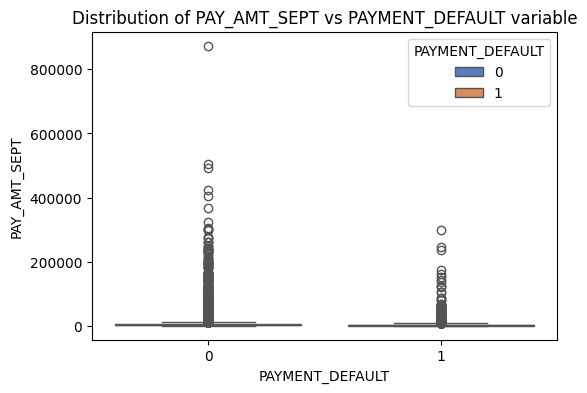



Pay_amt_aug Summary
                   count         mean           std  min     25%     50%  \
PAYMENT_DEFAULT                                                            
0                23364.0  6640.465074  25302.263601  0.0  1005.0  2247.5   
1                 6636.0  3388.649638  11737.986064  0.0     0.0  1533.5   

                     75%        max  
PAYMENT_DEFAULT                      
0                5311.25  1684259.0  
1                3309.75   358689.0  


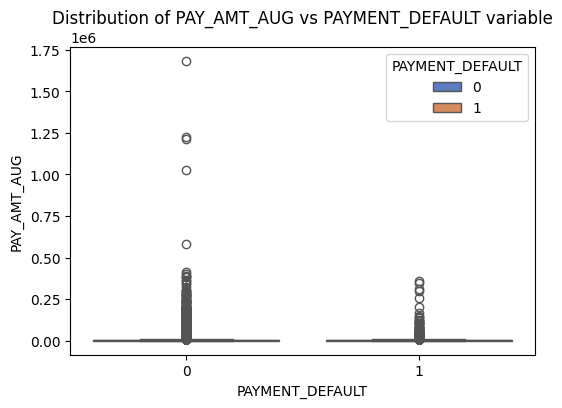



Pay_amt_jul Summary
                   count         mean           std  min    25%     50%  \
PAYMENT_DEFAULT                                                           
0                23364.0  5753.496833  18684.255937  0.0  600.0  2000.0   
1                 6636.0  3367.351567  12959.624486  0.0    0.0  1222.0   

                    75%       max  
PAYMENT_DEFAULT                    
0                5000.0  896040.0  
1                3000.0  508229.0  


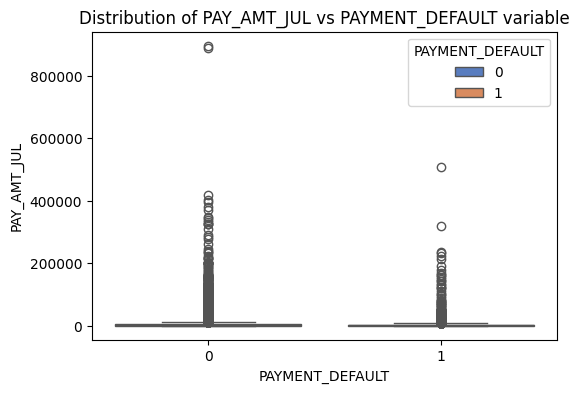



Pay_amt_jun Summary
                   count         mean           std  min    25%     50%  \
PAYMENT_DEFAULT                                                           
0                23364.0  5300.529319  16689.778060  0.0  390.0  1734.0   
1                 6636.0  3155.626733  11191.973162  0.0    0.0  1000.0   

                     75%       max  
PAYMENT_DEFAULT                     
0                4602.00  621000.0  
1                2939.25  432130.0  


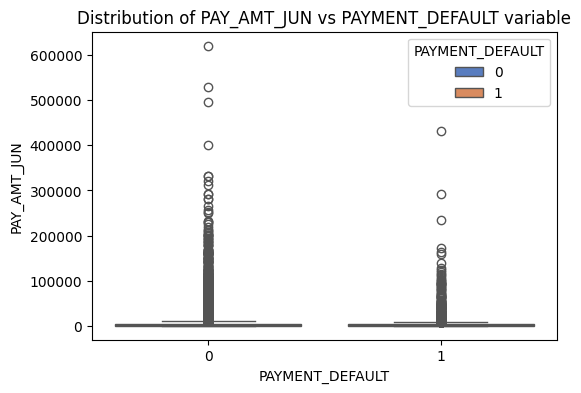



Pay_amt_may Summary
                   count         mean           std  min    25%     50%  \
PAYMENT_DEFAULT                                                           
0                23364.0  5248.220296  16071.667860  0.0  369.0  1765.0   
1                 6636.0  3219.139542  11944.731175  0.0    0.0  1000.0   

                    75%       max  
PAYMENT_DEFAULT                    
0                4600.0  426529.0  
1                3000.0  332000.0  


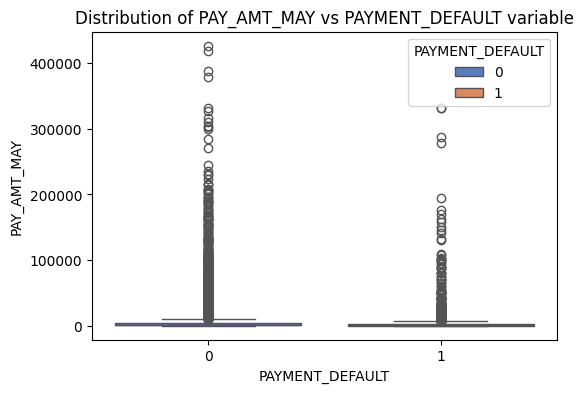



Pay_amt_apr Summary
                   count         mean           std  min    25%     50%  \
PAYMENT_DEFAULT                                                           
0                23364.0  5719.371769  18792.950473  0.0  300.0  1706.0   
1                 6636.0  3441.482068  13464.005894  0.0    0.0  1000.0   

                    75%       max  
PAYMENT_DEFAULT                    
0                4545.0  528666.0  
1                2974.5  345293.0  


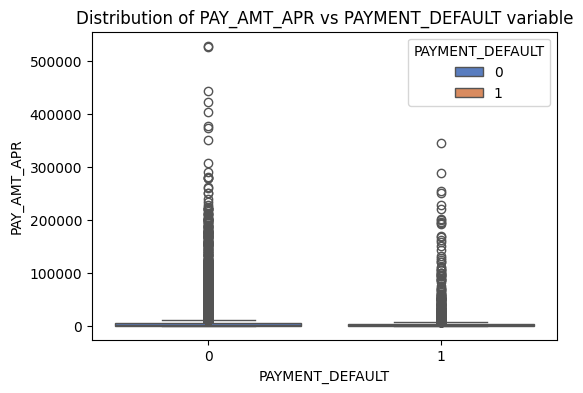

In [19]:
for col in num_cols:
  plotting_target_and_num_predictors(original_df, col, target_col, 'muted')

> #### **Section 3.4 Insights**

**Categorical**
- `SEX`: Females have a lower default rate (20.78%) than males (24.17%).
- `EDUCATION`: Default rates decrease with higher education:
  - Graduate school: 19.23%
  - University: 23.73%
  - High school: 25.16%
  - Others: 7.05%
- `MARRIAGE`: Single individuals have the lowest default rate (20.93%), followed by married (23.47%) and others (23.61%).

**Numerical**

- `LIMIT_BAL`:
  - Higher average for non-defaulters (`178,100` vs. `130,109` for defaulters).
  - Most non-defaulters have higher credit balances.

- `AGE`:
  - Similar averages between defaulters and non-defaulters (`35.42` vs. `35.73`).
  - Age distribution is similar for both groups.

- `PAY_APR` to `PAY_SEPT`:
  - Defaulters tend to have higher values, indicating late payments, compared to non-defaulters.
  - Non-defaulters have values close to `0` or negative, suggesting no late payments.

- `BILL_AMT_APR` to `BILL_AMT_SEPT`:
  - Non-defaulters have higher averages, indicating higher bill amounts.
  - Defaulters tend to have lower bill amounts compared to non-defaulters.

- `PAY_AMT_APR` to `PAY_AMT_SEPT`:
  - Defaulters tend to have lower payment amounts compared to non-defaulters.
  - The differences are notable, with defaulters showing lower averages in payments made.

Non-defaulters tend to have higher credit balances, higher bill amounts, and larger payments, while defaulters show lower values in most variables, suggesting a potential correlation between poor payment behavior and lower balances or payments.



## 4. Feature Selection

### 4.1 Feature Selection Approach 1: `Spearman Correlation`

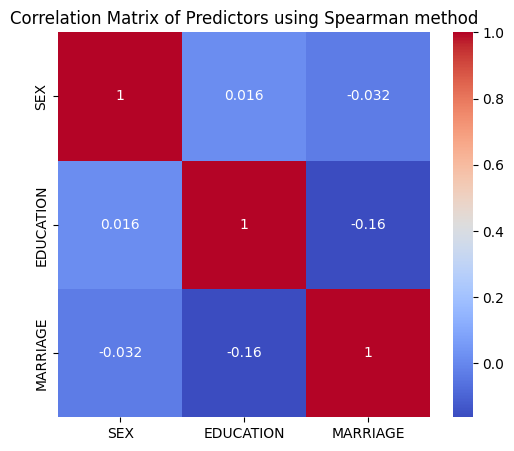

SEX  EDUCATION  MARRIAGE
SEX        1.000000   0.015616 -0.031535
EDUCATION  0.015616   1.000000 -0.162415
MARRIAGE  -0.031535  -0.162415  1.000000

In [20]:
get_corr_of_predictors('spearman', original_df, cat_cols)

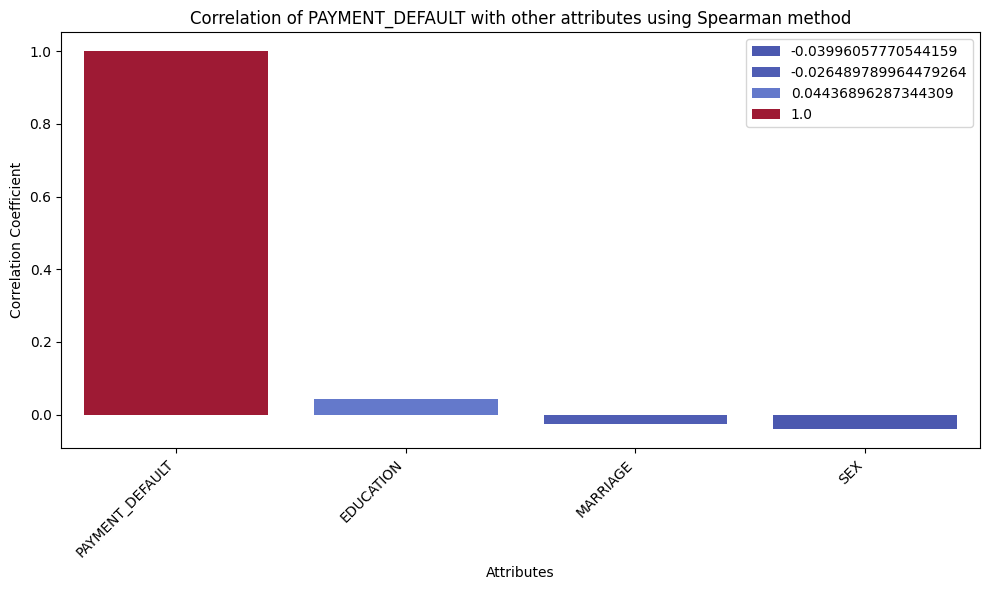

SEX  EDUCATION  MARRIAGE  PAYMENT_DEFAULT
SEX              1.000000   0.015616 -0.031535        -0.039961
EDUCATION        0.015616   1.000000 -0.162415         0.044369
MARRIAGE        -0.031535  -0.162415  1.000000        -0.026490
PAYMENT_DEFAULT -0.039961   0.044369 -0.026490         1.000000

In [21]:
get_corr_of_predictors_and_target('spearman', original_df, target_col, cat_cols+[target_col], 10, 6)

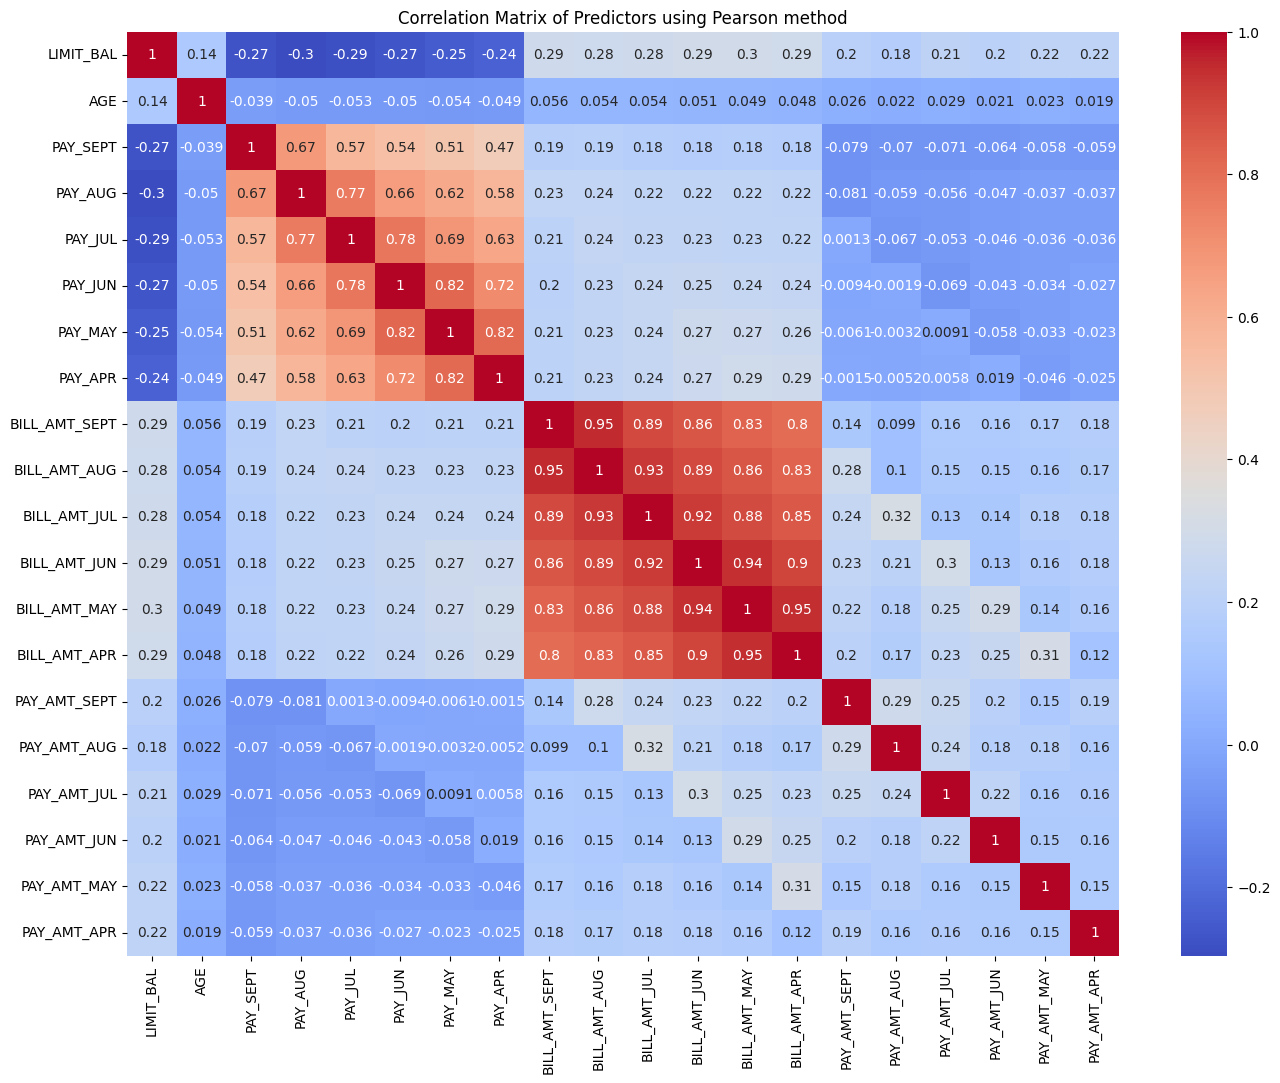

LIMIT_BAL       AGE  PAY_SEPT   PAY_AUG   PAY_JUL   PAY_JUN  \
LIMIT_BAL       1.000000  0.144713 -0.271214 -0.296382 -0.286123 -0.267460   
AGE             0.144713  1.000000 -0.039447 -0.050148 -0.053048 -0.049722   
PAY_SEPT       -0.271214 -0.039447  1.000000  0.672164  0.574245  0.538841   
PAY_AUG        -0.296382 -0.050148  0.672164  1.000000  0.766552  0.662067   
PAY_JUL        -0.286123 -0.053048  0.574245  0.766552  1.000000  0.777359   
PAY_JUN        -0.267460 -0.049722  0.538841  0.662067  0.777359  1.000000   
PAY_MAY        -0.249411 -0.053826  0.509426  0.622780  0.686775  0.819835   
PAY_APR        -0.235195 -0.048773  0.474553  0.575501  0.632684  0.716449   
BILL_AMT_SEPT   0.285430  0.056239  0.187068  0.234887  0.208473  0.202812   
BILL_AMT_AUG    0.278314  0.054283  0.189859  0.235257  0.237295  0.225816   
BILL_AMT_JUL    0.283236  0.053710  0.179785  0.224146  0.227494  0.244983   
BILL_AMT_JUN    0.293988  0.051353  0.179125  0.222237  0.227202  0.245917   
BILL_AMT_MAY    0.295562  0.049345  0.180635  0.221348  0.225145  0.242902   
BILL_AMT_APR    0.290389  0.047613  0.176980  0.219403  0.222327  0.239154   
PAY_AMT_SEPT    0.195236  0.026147 -0.079269 -0.080701  0.001295 -0.009362   
PAY_AMT_AUG     0.178408  0.021785 -0.070101 -0.058990 -0.066793 -0.001944   
PAY_AMT_JUL     0.210167  0.029247 -0.070561 -0.055901 -0.053311 -0.069235   
PAY_AMT_JUN     0.203242  0.021379 -0.064005 -0.046858 -0.046067 -0.043461   
PAY_AMT_MAY     0.217202  0.022850 -0.058190 -0.037093 -0.035863 -0.033590   
PAY_AMT_APR     0.219595  0.019478 -0.058673 -0.036500 -0.035861 -0.026565   

                PAY_MAY   PAY_APR  BILL_AMT_SEPT  BILL_AMT_AUG  BILL_AMT_JUL  \
LIMIT_BAL     -0.249411 -0.235195       0.285430      0.278314      0.283236   
AGE           -0.053826 -0.048773       0.056239      0.054283      0.053710   
PAY_SEPT       0.509426  0.474553       0.187068      0.189859      0.179785   
PAY_AUG        0.622780  0.575501       0.234887      0.235257      0.224146   
PAY_JUL        0.686775  0.632684       0.208473      0.237295      0.227494   
PAY_JUN        0.819835  0.716449       0.202812      0.225816      0.244983   
PAY_MAY        1.000000  0.816900       0.206684      0.226913      0.243335   
PAY_APR        0.816900  1.000000       0.207373      0.226924      0.241181   
BILL_AMT_SEPT  0.206684  0.207373       1.000000      0.951484      0.892279   
BILL_AMT_AUG   0.226913  0.226924       0.951484      1.000000      0.928326   
BILL_AMT_JUL   0.243335  0.241181       0.892279      0.928326      1.000000   
BILL_AMT_JUN   0.271915  0.266356       0.860272      0.892482      0.923969   
BILL_AMT_MAY   0.269783  0.290894       0.829779      0.859778      0.883910   
BILL_AMT_APR   0.262509  0.285091       0.802650      0.831594      0.853320   
PAY_AMT_SEPT  -0.006089 -0.001496       0.140277      0.280365      0.244335   
PAY_AMT_AUG   -0.003191 -0.005223       0.099355      0.100851      0.316936   
PAY_AMT_JUL    0.009062  0.005834       0.156887      0.150718      0.130011   
PAY_AMT_JUN   -0.058299  0.019018       0.158303      0.147398      0.143405   
PAY_AMT_MAY   -0.033337 -0.046434       0.167026      0.157957      0.179712   
PAY_AMT_APR   -0.023027 -0.025299       0.179341      0.174256      0.182326   

               BILL_AMT_JUN  BILL_AMT_MAY  BILL_AMT_APR  PAY_AMT_SEPT  \
LIMIT_BAL          0.293988      0.295562      0.290389      0.195236   
AGE                0.051353      0.049345      0.047613      0.026147   
PAY_SEPT           0.179125      0.180635      0.176980     -0.079269   
PAY_AUG            0.222237      0.221348      0.219403     -0.080701   
PAY_JUL            0.227202      0.225145      0.222327      0.001295   
PAY_JUN            0.245917      0.242902      0.239154     -0.009362   
PAY_MAY            0.271915      0.269783      0.262509     -0.006089   
PAY_APR            0.266356      0.290894      0.285091     -0.001496   
BILL_AMT_SEPT      0.860272      0.829

In [22]:
get_corr_of_predictors('pearson', original_df, num_cols, 16, 12)

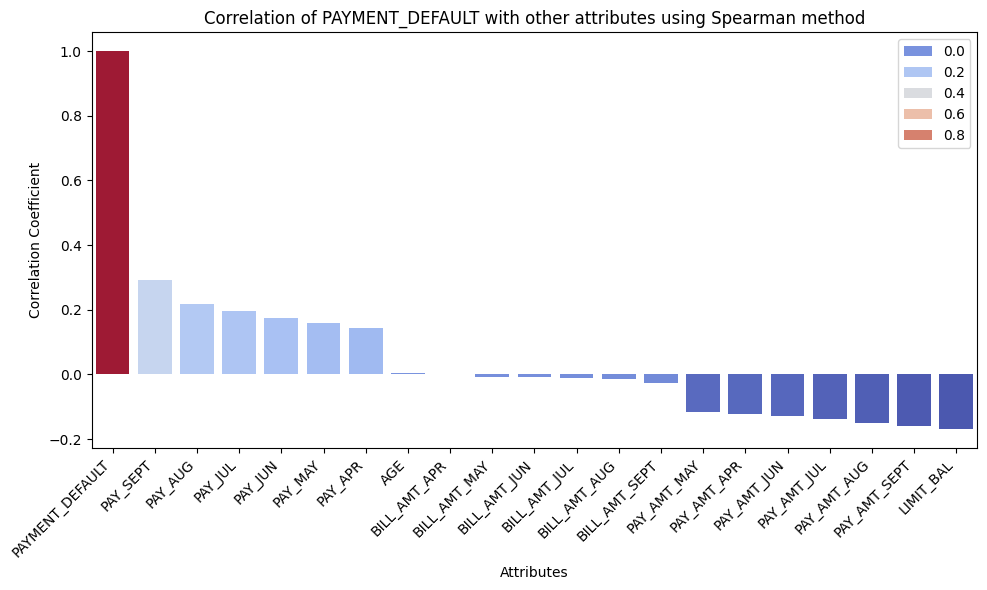

LIMIT_BAL       AGE  PAY_SEPT   PAY_AUG   PAY_JUL   PAY_JUN  \
LIMIT_BAL         1.000000  0.186485 -0.296461 -0.342596 -0.331615 -0.308658   
AGE               0.186485  1.000000 -0.063733 -0.083271 -0.083192 -0.080190   
PAY_SEPT         -0.296461 -0.063733  1.000000  0.627170  0.548112  0.516156   
PAY_AUG          -0.342596 -0.083271  0.627170  1.000000  0.799388  0.713212   
PAY_JUL          -0.331615 -0.083192  0.548112  0.799388  1.000000  0.801047   
PAY_JUN          -0.308658 -0.080190  0.516156  0.713212  0.801047  1.000000   
PAY_MAY          -0.284936 -0.083149  0.486441  0.673749  0.718457  0.822179   
PAY_APR          -0.264105 -0.076144  0.463892  0.635207  0.671428  0.731866   
BILL_AMT_SEPT     0.054384  0.001019  0.314574  0.571325  0.524146  0.512443   
BILL_AMT_AUG      0.048586  0.001513  0.329814  0.551146  0.588586  0.558359   
BILL_AMT_JUL      0.060617  0.001831  0.314329  0.518599  0.557356  0.619312   
BILL_AMT_JUN      0.072894 -0.003330  0.306818  0.497540  0.531436  0.592718   
BILL_AMT_MAY      0.080694 -0.000342  0.298782  0.478029  0.507209  0.561290   
BILL_AMT_APR      0.088094  0.000217  0.289055  0.459427  0.484530  0.533639   
PAY_AMT_SEPT      0.272367  0.033580 -0.098315  0.020401  0.215548  0.185478   
PAY_AMT_AUG       0.278401  0.044192 -0.063549  0.083520  0.037020  0.246221   
PAY_AMT_JUL       0.284468  0.033356 -0.054153  0.087311  0.103370  0.069251   
PAY_AMT_JUN       0.283411  0.040529 -0.034312  0.095036  0.118790  0.144446   
PAY_AMT_MAY       0.293749  0.038125 -0.026223  0.099155  0.124204  0.161743   
PAY_AMT_APR       0.317459  0.038977 -0.045015  0.082265  0.098356  0.142570   
PAYMENT_DEFAULT  -0.169586  0.005149  0.292213  0.216919  0.194771  0.173690   

                  PAY_MAY   PAY_APR  BILL_AMT_SEPT  BILL_AMT_AUG  ...  \
LIMIT_BAL       -0.284936 -0.264105       0.054384      0.048586  ...   
AGE             -0.083149 -0.076144       0.001019      0.001513  ...   
PAY_SEPT         0.486441  0.463892       0.314574      0.329814  ...   
PAY_AUG          0.673749  0.635207       0.571325      0.551146  ...   
PAY_JUL          0.718457  0.671428       0.524146      0.588586  ...   
PAY_JUN          0.822179  0.731866       0.512443      0.558359  ...   
PAY_MAY          1.000000  0.820880       0.499136      0.537640  ...   
PAY_APR          0.820880  1.000000       0.488392      0.523644  ...   
BILL_AMT_SEPT    0.499136  0.488392       1.000000      0.911133  ...   
BILL_AMT_AUG     0.537640  0.523644       0.911133      1.000000  ...   
BILL_AMT_JUL     0.587022  0.561061       0.857723      0.907740  ...   
BILL_AMT_JUN     0.649666  0.606196       0.807302      0.848381  ...   
BILL_AMT_MAY     0.618225  0.667710       0.769048      0.802947  ...   
BILL_AMT_APR     0.579321  0.629897       0.734275      0.765220  ...   
PAY_AMT_SEPT     0.175423  0.177536       0.502339      0.635634  ...   
PAY_AMT_AUG      0.221993  0.199939       0.472158      0.497603  ...   
PAY_AMT_JUL      0.260066  0.237571       0.440547      0.468164  ...   
PAY_AMT_JUN      0.106758  0.283836       0.441925      0.461064  ...   
PAY_AMT_MAY      0.184848  0.141080       0.424971      0.448785  ...   
PAY_AMT_APR      0.172170  0.197928       0.410465      0.429334  ...   
PAYMENT_DEFAULT  0.159043  0.142523      -0.025327     -0.015554  ...   

                 BILL_AMT_JUN  BILL_AMT_MAY  BILL_AMT_APR  PAY_AMT_SEPT  \
LIMIT_BAL            0.072894      0.080694      0.088094      0.272367   
AGE                 -0.003330     -0.000342      0.000217      0.033580   
PAY_SEPT             0.306818      0.298782      0.289055     -0.098315   
PAY_AUG              0.497540      0.478029      0.459427      0.020401   
PAY_JUL              0.531436      0.507209      0.484530      0.215548   
PAY_JUN              0.592718      0.561290      0.533639      0.185478   
PAY_MAY              0.649666      0.618225      0.579321      0.175423   
PAY_APR              0.606196      0.667710      

In [23]:
get_corr_of_predictors_and_target('spearman', original_df, target_col, num_cols+[target_col], 10, 6)


#### Section 4.1 Insights

**Categorical Variables**
- `SEX, EDUCATION, MARRIAGE, PAYMENT_DEFAULT`: Minimal correlations between these variables (values near 0). No significant relationships.

**Numerical Variables**
- `LIMIT_BAL`:
  - Weak positive correlation with `AGE` (0.19).
  - Negative correlation with overdue payments (`PAY_APR` to `PAY_SEPT`).
  - Positive correlation with `PAY_AMT_APR` to `PAY_AMT_SEPT`.
- `BILL_AMT_APR to BILL_AMT_SEPT`: Strong correlations among these variables, indicating that higher bills are consistent across months.
- `PAY_AMT_APR to PAY_AMT_SEPT`: Positive correlations, indicating consistency in payments.
- `PAYMENT_DEFAULT`: Negative correlation with most financial variables, suggesting defaults are associated with lower credit limits and smaller payments.

---

In this case, using Spearman's correlation allows us to understand relationships between both categorical and numerical features, helping to select the most informative variables for further analysis or modeling.

### 4.2 Final Selected Features

In [24]:
feature_selected = cat_cols + num_cols + [target_col]

print("Selected Features:")
print(feature_selected)

Selected Features:
['SEX', 'EDUCATION', 'MARRIAGE', 'LIMIT_BAL', 'AGE', 'PAY_SEPT', 'PAY_AUG', 'PAY_JUL', 'PAY_JUN', 'PAY_MAY', 'PAY_APR', 'BILL_AMT_SEPT', 'BILL_AMT_AUG', 'BILL_AMT_JUL', 'BILL_AMT_JUN', 'BILL_AMT_MAY', 'BILL_AMT_APR', 'PAY_AMT_SEPT', 'PAY_AMT_AUG', 'PAY_AMT_JUL', 'PAY_AMT_JUN', 'PAY_AMT_MAY', 'PAY_AMT_APR', 'PAYMENT_DEFAULT']


## 5. Data Preprocessing

### 5.1 Data Cleaning

#### 5.1.1 Create a copy of the dataset for data cleaning

In [25]:
df_cleaned = original_df[feature_selected].copy()

#### 5.1.2 Identify duplicates and drop duplicates

In [26]:
duplicates = df_cleaned.duplicated()
df_cleaned[duplicates].shape

(35, 24)

In [27]:
df_cleaned = df_cleaned.drop_duplicates()

#### Section 5.1 Insights

A total of 35 duplicate rows were identified and removed from the dataset to improve data quality and ensure more accurate analysis.

### 5.2 Feature Engineering

#### 5.2.1 Create a copy of the dataset for feature Engineering

In [28]:
df_engineered = df_cleaned.copy()

#### 5.2.2 Create a new variable called `PAYMENT_VALUE`

In [29]:
df_engineered['PAYMENT_VALUE'] = df_cleaned['PAY_SEPT'] + df_cleaned['PAY_AUG'] + df_cleaned['PAY_JUL'] + df_cleaned['PAY_JUN'] + df_cleaned['PAY_MAY'] + df_cleaned['PAY_APR']

#### 5.2.3 Create a new variable called `DUES`

In [30]:
df_engineered['DUES'] = (df_cleaned['BILL_AMT_APR']+df_cleaned['BILL_AMT_MAY']+df_cleaned['BILL_AMT_JUN']+df_cleaned['BILL_AMT_JUL']+df_cleaned['BILL_AMT_SEPT'])-(df_cleaned['PAY_AMT_APR']+df_cleaned['PAY_AMT_MAY']+df_cleaned['PAY_AMT_JUN']+df_cleaned['PAY_AMT_JUL']+df_cleaned['PAY_AMT_AUG']+df_cleaned['PAY_AMT_SEPT'])

#### Section 5.2 Insights

Two new features were created: `PAYMENT_VALUE`, representing the total repayment status over six months, and `DUES`, capturing the difference between total billed amounts and total payments, indicating overall outstanding debt.

### 5.3 Data Transformation

This section applies domain knowledge to create more meaningful encodings
of our categorical variables, making them more suitable for modeling.

In [31]:
df_transformed = df_engineered.copy()

# Custom encoding for SEX: Binary encoding (0=male, 1=female)
df_transformed['SEX'] = df_transformed['SEX'].map({1: 0, 2: 1})

# Custom encoding for EDUCATION: Ordinal with meaningful order
# Note: Lower values = lower education level
education_map = {
    3: 0,   # High school (lowest)
    2: 1,   # University (middle)
    1: 2,   # Graduate school (highest)
    4: -1,  # Others (unknown)
    5: -1,  # Unknown
    6: -1   # Unknown
}
df_transformed['EDUCATION'] = df_transformed['EDUCATION'].map(education_map)

# Custom encoding for MARRIAGE: Married vs Single with Others separate
marriage_map = {
    1: 1,   # Married
    2: 0,   # Single
    3: -1   # Others
}
df_transformed['MARRIAGE'] = df_transformed['MARRIAGE'].map(marriage_map)

# Verify the transformations
print("New value counts after encoding:")
print("SEX:\n", df_transformed['SEX'].value_counts())
print("EDUCATION:\n", df_transformed['EDUCATION'].value_counts())
print("MARRIAGE:\n", df_transformed['MARRIAGE'].value_counts())


New value counts after encoding:
SEX:
 SEX
1    18091
0    11874
Name: count, dtype: int64
EDUCATION:
 EDUCATION
 1.0    14019
 2.0    10563
 0.0     4915
-1.0      454
Name: count, dtype: int64
MARRIAGE:
 MARRIAGE
 0.0    15945
 1.0    13643
-1.0      323
Name: count, dtype: int64


## 6. Split the dataset

### 6.1 Split the dataset

In [32]:
y = df_transformed.pop('PAYMENT_DEFAULT')
X = df_transformed

In [33]:
# hold‑out test 30 %, then split remaining 70 % into train/val 70 : 30
X_eval, X_test, y_eval, y_test = train_test_split(X, y, test_size=0.30,
                                                 stratify=y, random_state=42)
X_train, X_val,  y_train, y_val = train_test_split(X_eval, y_eval,
                                                 test_size=0.30,
                                                 stratify=y_eval,
                                                 random_state=42)

### 6.2 Save datasets

In [34]:
try:
  X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
  y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

  X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
  y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

  X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
  y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
except Exception as e:
  print(e)

#### Section 6 Insights

The target variable `y` (`PAYMENT_DEFAULT`) was separated from the features `X`. The dataset was split into training (49%), validation (21%), and test (30%) sets. All subsets of `X` and `y` were then saved as CSV files for later use in model development and evaluation.

## 7. Data Modeling

### 7.1 Generate Predictions with Baseline Model

In [35]:
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

### 7.2 Assess the Baseline Model

In [36]:
y_dummy_preds = baseline_model.predict(X_val)
y_dummy_probs = baseline_model.predict_proba(X_val)[:, 1]

results_dummy = {
    "Accuracy": accuracy_score(y_val, y_dummy_preds),
    "Precision": precision_score(y_val, y_dummy_preds, zero_division=0),
    "Recall": recall_score(y_val, y_dummy_preds, zero_division=0),
    "F1": f1_score(y_val, y_dummy_preds, zero_division=0),
    "AUC": roc_auc_score(y_val, y_dummy_probs)
}

results_df = pd.DataFrame([results_dummy])
print(results_df.T)
print("Confusion Matrix:\n", confusion_matrix(y_val, y_dummy_preds))

                  0
Accuracy   0.778802
Precision  0.000000
Recall     0.000000
F1         0.000000
AUC        0.500000
Confusion Matrix:
 [[4901    0]
 [1392    0]]


### 7.3 Generate models

This section implements the predictive modeling approach in our business case by building
and evaluating three different models (Decision Tree, Logistic Regression, and Random Forest).
These models will help us identify customers at risk of default and inform credit policy decisions.

In [37]:
pay_vars = ['PAY_SEPT', 'PAY_AUG', 'PAY_JUL',
           'PAY_JUN', 'PAY_MAY', 'PAY_APR']

cat_cols = pay_vars + ['SEX', 'EDUCATION', 'MARRIAGE']
num_cols = [c for c in X_train.columns if c not in cat_cols]

preproc = ColumnTransformer([
    ('num', RobustScaler(), num_cols),  # Scale numerical features
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), pay_vars)
])

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    results = {
        split: {
            "Accuracy": accuracy_score(y, model.predict(X)),
            "Precision": precision_score(y, model.predict(X)),
            "Recall": recall_score(y, model.predict(X)),
            "F1": f1_score(y, model.predict(X)),
            "AUC": roc_auc_score(y, model.predict_proba(X)[:, 1])
        }
        for split, (X, y) in {
            "train": (X_train, y_train),
            "val": (X_val, y_val),
            "test": (X_test, y_test)
        }.items()
    }
    return pd.DataFrame(results).T

#### 7.3.1 Decision Tree

In [38]:
tree_params = {'clf__max_depth':[5,20,30,50,None],
              'clf__min_samples_split': [0.1, 0.2, 0.4]}

tree_pipe = Pipeline([
    ('prep', preproc),
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(random_state=42))
])

tree_grid = GridSearchCV(tree_pipe, tree_params,scoring='f1', cv=5, n_jobs=-1)
tree_grid.fit(X_train, y_train)
best_tree = tree_grid.best_estimator_

print("Decision Tree – best params:", tree_grid.best_params_)
tree_results = evaluate_model(best_tree, X_train, y_train, X_val, y_val, X_test, y_test)
print(tree_results)

Decision Tree – best params: {'clf__max_depth': 20, 'clf__min_samples_split': 0.1}
       Accuracy  Precision    Recall        F1       AUC
train  0.734777   0.434358  0.656817  0.522911  0.772283
val    0.726839   0.423776  0.653017  0.513995  0.763268
test   0.720022   0.413215  0.631976  0.499702  0.746666


#### 7.3.2 Logistic Regression

In [39]:
logreg_params = {'clf__C':[0.01,0.1,1,10]}

logreg_pipe = Pipeline([
    ('prep', preproc),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=2000, solver='saga',
                              penalty='elasticnet', l1_ratio=0.5,
                              class_weight='balanced', random_state=42))
])

logreg_grid = GridSearchCV(logreg_pipe, logreg_params, scoring='f1', cv=5, n_jobs=-1)
logreg_grid.fit(X_train, y_train)
best_logreg = logreg_grid.best_estimator_

print("Logistic Regression – best params:", logreg_grid.best_params_)
logreg_results = evaluate_model(best_logreg, X_train, y_train, X_val, y_val, X_test, y_test)
print(logreg_results)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression – best params: {'clf__C': 10}
       Accuracy  Precision    Recall        F1       AUC
train  0.723198   0.415962  0.620806  0.498148  0.729879
val    0.723979   0.417107  0.623563  0.499856  0.734815
test   0.721913   0.414577  0.623429  0.497992  0.725547


#### 7.3.3 Random Forest

In [40]:
rf_params = {
    'clf__n_estimators': [100, 150],
    'clf__max_depth': [5, 8, 10],
    'clf__min_samples_leaf': [4, 8],
    'clf__min_samples_split': [8, 12],
    'clf__max_features': ['sqrt', 0.5]
}

rf_pipe = Pipeline([
    ('prep', preproc),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42))
])

rf_grid = GridSearchCV(rf_pipe, rf_params, scoring='f1', cv=5, n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

print("Random Forest – best params:", rf_grid.best_params_)
rf_results = evaluate_model(best_rf, X_train, y_train, X_val, y_val, X_test, y_test)
print(rf_results)

Random Forest – best params: {'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 12, 'clf__n_estimators': 100}
       Accuracy  Precision    Recall        F1       AUC
train  0.761749   0.471788  0.640813  0.543461  0.785889
val    0.754807   0.460367  0.630029  0.531999  0.777071
test   0.752836   0.457404  0.628959  0.529636  0.765514


#### 7.3.4 Save Results

In [41]:
best_models = {
    "Tree": best_tree,
    "LogReg": best_logreg,
    "RF": best_rf
}

results = {
    "Tree": {split: row.to_dict() for split, row in tree_results.iterrows()},
    "LogReg": {split: row.to_dict() for split, row in logreg_results.iterrows()},
    "RF": {split: row.to_dict() for split, row in rf_results.iterrows()}
}

print(f"Models trained: {list(best_models.keys())}")
print(f"Data splits: {list(results['Tree'].keys())}")
print(f"Metrics available: {list(results['Tree']['test'].keys())}")

Models trained: ['Tree', 'LogReg', 'RF']
Data splits: ['train', 'val', 'test']
Metrics available: ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']


### 7.4 Models insights

The evaluation metrics across our three models (Decision Tree, Logistic Regression, and Random Forest) reveal important patterns that inform our credit policy recommendations:

#### Decision Tree
* The model achieved approximately 72% accuracy on test data with consistent performance across train and validation sets
* Best hyperparameters include a deeper tree (depth=20) and minimal split threshold (0.1)
* The F1 score of 0.50 on test data indicates a reasonable balance between precision and recall
* Demonstrates good recall (63.2% on test data), capturing a significant portion of actual defaulters
* Despite the increased depth, still provides interpretable decision paths for deriving credit policy rules

#### Logistic Regression
* Shows comparable accuracy (72.2% on test data) to the Decision Tree model
* Exhibits strong recall (62.3% on test data), effectively detecting many actual defaulters
* Precision (41.5%) indicates some false positives, which may lead to moderately conservative credit policies
* The high regularization strength (C=10) suggests the model benefits from retaining feature complexity
* Very consistent performance across train, validation, and test sets, indicating stable generalization

#### Random Forest
* Demonstrates the highest accuracy (75.3% on test) and AUC (0.766) across all models
* Shows the best overall F1 score (0.530) with a good balance of precision (45.7%) and recall (62.9%)
* Best hyperparameters include moderate tree depth (5), feature selection via sqrt criterion, and ensemble size of 100 trees
* More resistant to overfitting than expected, with relatively close performance between training and test sets
* The ensemble approach captures complex patterns while maintaining reasonable interpretability with controlled tree depth

#### Key Tradeoffs
* Random Forest provides the best overall predictive performance across all metrics
* Decision Tree offers a good balance of performance and interpretability, with slightly higher recall than Logistic Regression
* Logistic Regression shows the most consistent performance across data splits, suggesting reliable generalization
* All models demonstrate AUC values between 0.73-0.77, indicating good discriminative ability

#### Business Relevance
* Random Forest provides the most robust model for credit risk assessment with the best overall metrics
* Decision Tree can be converted into explicit policy rules, though the deeper tree structure (depth=20) requires careful pruning for business implementation
* All models show consistent train/validation/test performance, suggesting they will generalize well to new customers
* The recall rates around 62-63% across all models indicate we can identify a significant portion of potential defaulters

### 7.5 Logistic Regression Scorecard

####Strengths:

Good Risk Segmentation: There is a smooth and gradual increase in bad rate from lower to higher ranges in train, validation, and test sets. For example, bad rates in Train vary from 8.23% (Range 1) to 71.41% (Range 22).

Good Stability Across Sets: Bad rate curves between Train, Validation, and Test are very comparable with each other, which shows that the model generalizes well.

Good Risk Capture Early: Rejecting from Range 17+ (probability >0.53) already captures a significant number of bads (~47% of bads) at the cost of rejecting only around 15% of the population.

####Weaknesses:

Some Volatility in Middle Ranges: Validation/Test bad rates slightly fluctuate between Ranges 5–11, reflecting small instability in mid-risk customers.

Higher Loss in Good Customers: Rejecting after Range 17 also starts compromising more good customers (e.g., ~47% bads captured but ~15% goods lost).

Dataset    Lower Prob  Upper Prob  Number of Goods  Number of Bads  \
Range 1    Train  4.146130e-11    0.161473              613              55   
Range 2    Train  1.614727e-01    0.206893              604              63   
Range 3    Train  2.068927e-01    0.238380              590              77   
Range 4    Train  2.383796e-01    0.269071              584              84   
Range 5    Train  2.690708e-01    0.303086              595              72   
Range 6    Train  3.030859e-01    0.332779              573              94   
Range 7    Train  3.327787e-01    0.356529              560             108   
Range 8    Train  3.565294e-01    0.381615              570              97   
Range 9    Train  3.816153e-01    0.404774              586              81   
Range 10   Train  4.047736e-01    0.424145              582              86   
Range 11   Train  4.241454e-01    0.442335              588              79   
Range 12   Train  4.423346e-01    0.458678              591              76   
Range 13   Train  4.586783e-01    0.473036              576              92   
Range 14   Train  4.730365e-01    0.488330              568              99   
Range 15   Train  4.883297e-01    0.504941              572              95   
Range 16   Train  5.049412e-01    0.528158              522             146   
Range 17   Train  5.281580e-01    0.561281              518             149   
Range 18   Train  5.612805e-01    0.616998              481             186   
Range 19   Train  6.169981e-01    0.685685              402             266   
Range 20   Train  6.856849e-01    0.755676              314             353   
Range 21   Train  7.556757e-01    0.820449              253             414   
Range 22   Train  8.204485e-01    0.997295              191             477   
TOTAL      TOTAL           NaN         NaN            11433            3249   

          Total Amount  Sum BAL Goods  Sum BAL Bads Relative Total Percentage  \
Range 1            668      217520000      19330000                     4.55%   
Range 2            667      192320000      20100000                     4.54%   
Range 3            667      156920000      20510000                     4.54%   
Range 4            668      140310000      20710000                     4.55%   
Range 5            667      149470000      15420000                     4.54%   
Range 6            667      134200000      19390000                     4.54%   
Range 7            668      120470000      20840000                     4.55%   
Range 8            667      116140000      16710000                     4.54%   
Range 9            667      113970000      12160000                     4.54%   
Range 10           668      100710000      10950000                     4.55%   
Range 11           667       91480000      11100000                     4.54%   
Range 12           667       72130000       9330000                     4.54%   
Range 13           668       65870000       8920000                     4.55%   
Range 14           667       50450000       9560000                     4.54%   
Range 15           667       49030000       7140000                     4.54%   
Range 16           668       45340000      12910000                     4.55%   
Range 17           667       55676000      18790000                     4.54%   
Range 18           667       60530000      27020000                     4.54%   
Range 19           668       46610000      34200000                     4.55%   
Range 20           667       28260000      34110000                     4.54%   
Range 21           667       19510000      37080000                     4.54%   
Range 22           668       12136000      35630000                     4.55%   
TOTAL            14682     2039052000     421910000                             

         Bad Rate Bad Rate Acum % of Total Acum % of Bads Acum % of Goods Acum  
Range 1     8.23%         8.23%           4.55%          1.69%           5.36%  
Range

Dataset    Lower Prob  Upper Prob  Number of Goods  \
Range 1   Validation  4.146130e-11    0.161473              266   
Range 2   Validation  1.614727e-01    0.206893              204   
Range 3   Validation  2.068927e-01    0.238380              257   
Range 4   Validation  2.383796e-01    0.269071              260   
Range 5   Validation  2.690708e-01    0.303086              276   
Range 6   Validation  3.030859e-01    0.332779              277   
Range 7   Validation  3.327787e-01    0.356529              242   
Range 8   Validation  3.565294e-01    0.381615              275   
Range 9   Validation  3.816153e-01    0.404774              237   
Range 10  Validation  4.047736e-01    0.424145              241   
Range 11  Validation  4.241454e-01    0.442335              232   
Range 12  Validation  4.423346e-01    0.458678              248   
Range 13  Validation  4.586783e-01    0.473036              246   
Range 14  Validation  4.730365e-01    0.488330              260   
Range 15  Validation  4.883297e-01    0.504941              227   
Range 16  Validation  5.049412e-01    0.528158              236   
Range 17  Validation  5.281580e-01    0.561281              193   
Range 18  Validation  5.612805e-01    0.616998              237   
Range 19  Validation  6.169981e-01    0.685685              164   
Range 20  Validation  6.856849e-01    0.755676              134   
Range 21  Validation  7.556757e-01    0.820449              123   
Range 22  Validation  8.204485e-01    0.997295               66   
TOTAL          TOTAL           NaN         NaN             4901   

          Number of Bads  Total Amount  Sum BAL Goods  Sum BAL Bads  \
Range 1               24           290       91960000       7780000   
Range 2               17           221       62410000       5180000   
Range 3               41           298       69790000      10950000   
Range 4               29           289       63100000       7710000   
Range 5               37           313       66310000       8737680   
Range 6               35           312       66880000       6740000   
Range 7               44           286       54100000       8180000   
Range 8               39           314       56020000       6600000   
Range 9               45           282       46420000       7960000   
Range 10              30           271       43600000       5160000   
Range 11              28           260       34290000       3700000   
Range 12              38           286       31360000       4210000   
Range 13              39           285       24290000       3340000   
Range 14              44           304       21130000       5060000   
Range 15              50           277       19710000       4650000   
Range 16              44           280       21140000       4120000   
Range 17              64           257       20590000       9370000   
Range 18             104           341       30160000      15780000   
Range 19             106           270       18640000      13010000   
Range 20             157           291       12230000      13640000   
Range 21             194           317       10050000      17110000   
Range 22             183           249        4640000      13050000   
TOTAL               1392          6293      868820000     182037680   

         Relative Total Percentage Bad Rate Bad Rate Acum % of Total Acum  \
Range 1                      4.61%    8.28%         8.28%           4.61%   
Range 2                      3.51%    7.69%         8.02%           7.02%   
Range 3                      4.74%   13.76%        10.14%          14.21%   
Range 4                      4.59%   10.03%        10.11%          18.37%   
Range 5                      4.97%   11.82%        10.49%          24.87%   
Range 6                      4.96%   11.22%        10.62%          29.75%   
Range 7                      4.54%   15.38%         11.3%          31.81%   
Range 8                      4.99%   12.42%        11.45%          39.92%   
Range 

Dataset    Lower Prob  Upper Prob  Number of Goods  Number of Bads  \
Range 1     Test  4.146130e-11    0.161473              378              39   
Range 2     Test  1.614727e-01    0.206893              363              50   
Range 3     Test  2.068927e-01    0.238380              363              61   
Range 4     Test  2.383796e-01    0.269071              358              37   
Range 5     Test  2.690708e-01    0.303086              337              58   
Range 6     Test  3.030859e-01    0.332779              381              61   
Range 7     Test  3.327787e-01    0.356529              360              52   
Range 8     Test  3.565294e-01    0.381615              386              48   
Range 9     Test  3.816153e-01    0.404774              374              57   
Range 10    Test  4.047736e-01    0.424145              320              40   
Range 11    Test  4.241454e-01    0.442335              349              49   
Range 12    Test  4.423346e-01    0.458678              342              52   
Range 13    Test  4.586783e-01    0.473036              325              47   
Range 14    Test  4.730365e-01    0.488330              367              57   
Range 15    Test  4.883297e-01    0.504941              336              67   
Range 16    Test  5.049412e-01    0.528158              334              76   
Range 17    Test  5.281580e-01    0.561281              304             101   
Range 18    Test  5.612805e-01    0.616998              332             127   
Range 19    Test  6.169981e-01    0.685685              237             152   
Range 20    Test  6.856849e-01    0.755676              200             211   
Range 21    Test  7.556757e-01    0.820449              148             263   
Range 22    Test  8.204485e-01    0.997295              107             284   
TOTAL      TOTAL           NaN         NaN             7001            1989   

          Total Amount  Sum BAL Goods  Sum BAL Bads Relative Total Percentage  \
Range 1            417      130420000      13730000                     4.64%   
Range 2            413      116600000      17780000                     4.59%   
Range 3            424       95420000      16250000                     4.72%   
Range 4            395       88560000       9890000                     4.39%   
Range 5            395       85240000      13290000                     4.39%   
Range 6            442       88430000      11910000                     4.92%   
Range 7            412       77870000       9300000                     4.58%   
Range 8            434       80580000       7550000                     4.83%   
Range 9            431       73690000       7240000                     4.79%   
Range 10           360       56710000       5130000                      4.0%   
Range 11           398       51620000       6660000                     4.43%   
Range 12           394       42370000       5880000                     4.38%   
Range 13           372       34600000       4540000                     4.14%   
Range 14           424       33350000       5590000                     4.72%   
Range 15           403       28380000       5380000                     4.48%   
Range 16           410       28770000       6120000                     4.56%   
Range 17           405       30900000      12830000                     4.51%   
Range 18           459       41120000      16530000                     5.11%   
Range 19           389       25550000      18280000                     4.33%   
Range 20           411       19450000      19130000                     4.57%   
Range 21           411       12270000      22280000                     4.57%   
Range 22           391        5830000      22560000                     4.35%   
TOTAL             8990     1247730000     257850000                             

         Bad Rate Bad Rate Acum % of Total Acum % of Bads Acum % of Goods Acum  
Range 1     9.35%         9.35%           4.64%          1.96%            5.4%  
Range

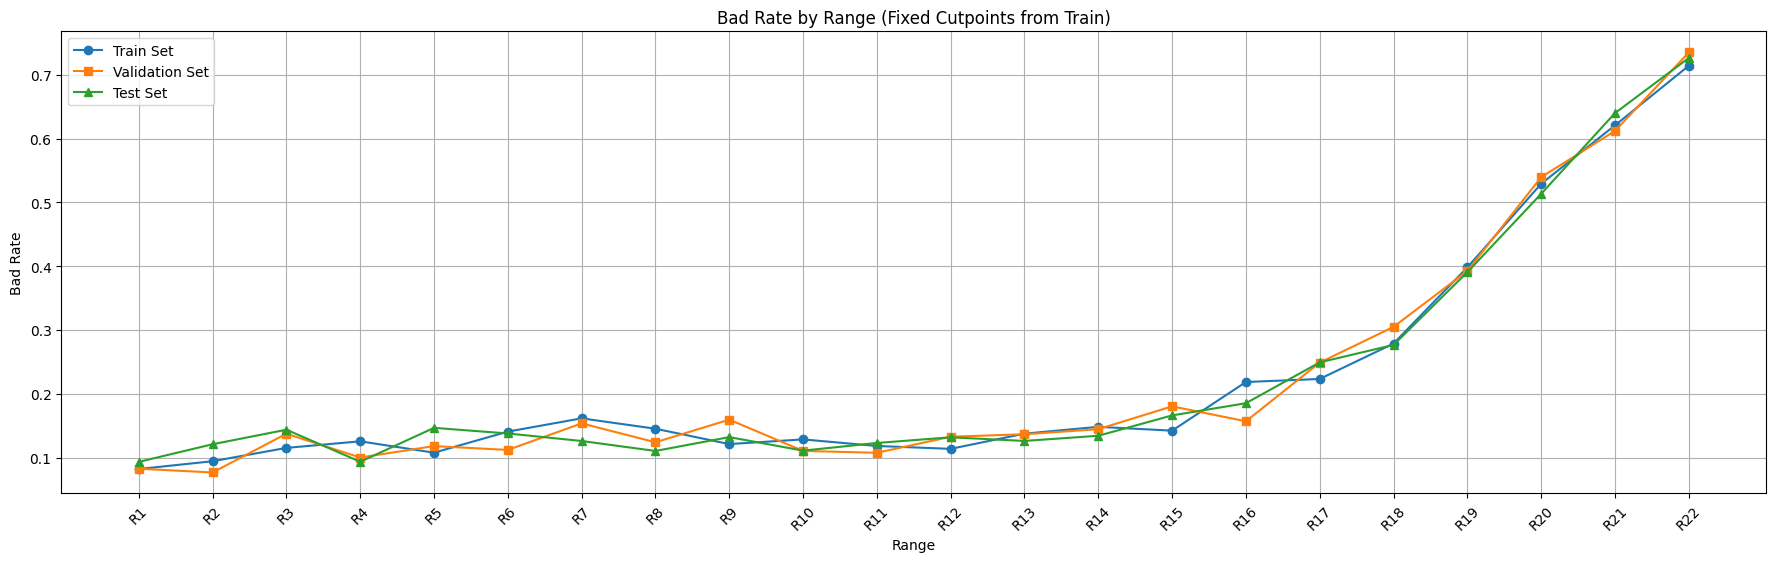

In [48]:
# 1. Predict probabilities
train_probs = best_logreg.predict_proba(X_train)[:, 1]
val_probs = best_logreg.predict_proba(X_val)[:, 1]
test_probs = best_logreg.predict_proba(X_test)[:, 1]

ranges = 22  # 22 bins

# 2. Create cutpoints based on Train only
train_df = pd.DataFrame({
    'prob': train_probs,
    'target': y_train.reset_index(drop=True),
    'LIMIT_BAL': X_train['LIMIT_BAL'].reset_index(drop=True)
})
train_df['range'], bins = pd.qcut(train_df['prob'], q=ranges, retbins=True, labels=False, duplicates='drop')

# 3. Define function to create table using FIXED bins
def create_fixed_range_table(probs, targets, limit_balances, dataset_name, bins):
    df = pd.DataFrame({
        'prob': probs,
        'target': targets.reset_index(drop=True),
        'LIMIT_BAL': limit_balances.reset_index(drop=True)
    })
    df['range'] = pd.cut(df['prob'], bins=bins, labels=False, include_lowest=True)

    table = []
    total_records = len(df)
    total_bads = (df['target'] == 1).sum()
    total_goods = (df['target'] == 0).sum()

    cumulative_bads = 0
    cumulative_goods = 0

    for bin_num in sorted(df['range'].dropna().unique()):
        subset = df[df['range'] == bin_num]
        lower_prob = bins[bin_num]
        upper_prob = bins[bin_num + 1]
        number_goods = (subset['target'] == 0).sum()
        number_bads = (subset['target'] == 1).sum()
        total_amount = number_goods + number_bads
        relative_percentage = total_amount / total_records
        bad_rate = number_bads / total_amount if total_amount > 0 else 0

        cumulative_bads += number_bads
        cumulative_goods += number_goods

        sum_limit_goods = subset[subset['target'] == 0]['LIMIT_BAL'].sum()
        sum_limit_bads = subset[subset['target'] == 1]['LIMIT_BAL'].sum()

        table.append({
            'Dataset': dataset_name,
            'Lower Prob': lower_prob,
            'Upper Prob': upper_prob,
            'Number of Goods': number_goods,
            'Number of Bads': number_bads,
            'Total Amount': total_amount,
            'Sum BAL Goods': int(sum_limit_goods),
            'Sum BAL Bads': int(sum_limit_bads),
            'Relative Total Percentage': relative_percentage,
            'Bad Rate': bad_rate,
            'Bad Rate Acum': cumulative_bads / (cumulative_bads + cumulative_goods) if (cumulative_bads + cumulative_goods) > 0 else 0,
            '% of Total Acum': (total_amount * (bin_num+1)) / total_records,
            '% of Bads Acum': cumulative_bads / total_bads if total_bads > 0 else 0,
            '% of Goods Acum': cumulative_goods / total_goods if total_goods > 0 else 0
        })

    result_table = pd.DataFrame(table)
    result_table.index = [f'Range {i+1}' for i in range(len(result_table))]

    # Format ONLY percentage columns
    percent_cols = ['Relative Total Percentage', 'Bad Rate', 'Bad Rate Acum',
                    '% of Total Acum', '% of Bads Acum', '% of Goods Acum']
    for col in percent_cols:
        result_table[col] = (result_table[col].astype(float) * 100).round(2).astype(str) + '%'

    # Add TOTAL row
    total_row = pd.DataFrame({
        'Dataset': ['TOTAL'],
        'Lower Prob': [None],
        'Upper Prob': [None],
        'Number of Goods': [result_table['Number of Goods'].astype(int).sum()],
        'Number of Bads': [result_table['Number of Bads'].astype(int).sum()],
        'Total Amount': [result_table['Total Amount'].astype(int).sum()],
        'Sum BAL Goods': [result_table['Sum BAL Goods'].astype(int).sum()],
        'Sum BAL Bads': [result_table['Sum BAL Bads'].astype(int).sum()],
        'Relative Total Percentage': [''],
        'Bad Rate': [result_table['Bad Rate Acum'].iloc[-1]],
        'Bad Rate Acum': [''],
        '% of Total Acum': [''],
        '% of Bads Acum': [''],
        '% of Goods Acum': ['']
    }, index=['TOTAL'])

    result_table = pd.concat([result_table, total_row])

    display(result_table)
    return result_table

# 4. Create tables
train_table = create_fixed_range_table(train_probs, y_train, X_train['LIMIT_BAL'], 'Train', bins)
val_table = create_fixed_range_table(val_probs, y_val, X_val['LIMIT_BAL'], 'Validation', bins)
test_table = create_fixed_range_table(test_probs, y_test, X_test['LIMIT_BAL'], 'Test', bins)

# 5. Plot Bad Rates
plt.figure(figsize=(ranges, 6))

# Exclude 'TOTAL' row
train_plot = train_table.drop('TOTAL')
val_plot = val_table.drop('TOTAL')
test_plot = test_table.drop('TOTAL')

# Convert 'Bad Rate' strings back to numeric
train_bad_rate = train_plot['Bad Rate'].str.rstrip('%').astype(float) / 100
val_bad_rate = val_plot['Bad Rate'].str.rstrip('%').astype(float) / 100
test_bad_rate = test_plot['Bad Rate'].str.rstrip('%').astype(float) / 100

# Plot
plt.plot(train_bad_rate, label='Train Set', marker='o')
plt.plot(val_bad_rate, label='Validation Set', marker='s')
plt.plot(test_bad_rate, label='Test Set', marker='^')

plt.title('Bad Rate by Range (Fixed Cutpoints from Train)')
plt.xlabel('Range')
plt.ylabel('Bad Rate')
plt.xticks(ticks=range(ranges), labels=[f'R{i+1}' for i in range(ranges)], rotation=45)
plt.legend()
plt.grid(True)
plt.show()

### 7.6 Random Tree Scorecard

####Strengths:

High Transparency and Simplicity:
Each "leaf" (node split) corresponds to a distinct customer segment, so it is very interpretable and also easily explain credit decisions to regulators, internal auditors, or business units.

Clean Bad Concentration at High Leaves:
The model concentrates the worst risk heavily at some leaves:

For example, Leaf 45 and Leaf 46 have bad rates over 65% and 78%, respectively, on train, validation, and test.

This sudden jump enables high-risk rejection strategies without rejecting too large a segment.

Good Capture of Extreme Defaults:
By disabling after worst leaves (i.e., rejecting customers in Leaf 45 and Leaf 46), It's possible eliminate an out-of-proportion number of bads (roughly 20% of all bads) by rejecting about 7–8% of customers.

####Weaknesses:
Coarser Risk Segmentation:
As compared to Logistic Regression or Random Forest, tree partitions customers into large buckets with fewer finer distinctions in risk segmentation. In one leaf node, It would put customers of different risk classes together.

Less Smooth Bad Rate Curve:
As compared to scorecard models that use continuous scoring, the bad rate curve in Random Tree models has abrupt jumps between leaves instead of changing smoothly. This may cause less flexible decision-making.

Possible Overfitting at Top Risk Leaves:
Some of the leaves (notably Leaf 46) contain extremely high bad rates (e.g., 78%) but also capture small proportions of the population. While this is an indicator of high risk discrimination, it is also an indicator of potential overfitting to training data in the most extreme segments.

Validation and Test Divergence at Mid-Ranges:
While the train and validation curves appear to be fine, there is a slight difference between Validation and Test datasets in leaves with mid-risk (e.g., Leaf 10–15). This suggests that the tree may not generalize entirely in customers with mid-risk.

In [49]:
# 1. Extract preprocessing and model
prep = best_tree.named_steps['prep']
clf = best_tree.named_steps['clf']

# 2. Transform X sets
X_train_prep = prep.transform(X_train)
X_val_prep = prep.transform(X_val)
X_test_prep = prep.transform(X_test)

# 3. Apply tree to get leaves
train_leaves = clf.apply(X_train_prep)
val_leaves = clf.apply(X_val_prep)
test_leaves = clf.apply(X_test_prep)

# 4. Helper function to summarize leaves
def summarize_leaves_final(leaves, targets, limit_balances, dataset_name):
    df = pd.DataFrame({
        'Leaf': leaves,
        'Target': targets.reset_index(drop=True),
        'LIMIT_BAL': limit_balances.reset_index(drop=True)
    })

    summary = df.groupby('Leaf').agg(
        Number_of_Goods=('Target', lambda x: (x == 0).sum()),
        Number_of_Bads=('Target', lambda x: (x == 1).sum()),
        Sum_Limit_Goods=('LIMIT_BAL', lambda x: x[df.loc[x.index, 'Target'] == 0].sum()),
        Sum_Limit_Bads=('LIMIT_BAL', lambda x: x[df.loc[x.index, 'Target'] == 1].sum())
    )

    summary['Total Amount'] = summary['Number_of_Goods'] + summary['Number_of_Bads']
    total_records = summary['Total Amount'].sum()
    total_goods = summary['Number_of_Goods'].sum()
    total_bads = summary['Number_of_Bads'].sum()

    summary['Relative Total Percentage'] = summary['Total Amount'] / total_records
    summary['Bad Rate'] = summary['Number_of_Bads'] / summary['Total Amount']

    # Cumulative columns
    summary = summary.sort_values(by='Bad Rate', ascending=True)
    summary['Cumulative Bads'] = summary['Number_of_Bads'].cumsum()
    summary['Cumulative Goods'] = summary['Number_of_Goods'].cumsum()

    summary['Bad Rate Acum'] = summary['Cumulative Bads'] / (summary['Cumulative Bads'] + summary['Cumulative Goods'])
    summary['% of Total Acum'] = summary['Total Amount'].cumsum() / total_records
    summary['% of Bads Acum'] = summary['Cumulative Bads'] / total_bads
    summary['% of Goods Acum'] = summary['Cumulative Goods'] / total_goods

    # Format percentages only
    summary['Relative Total Percentage'] = (summary['Relative Total Percentage'] * 100).round(2).astype(str) + '%'
    summary['Bad Rate'] = (summary['Bad Rate'] * 100).round(2).astype(str) + '%'
    summary['Bad Rate Acum'] = (summary['Bad Rate Acum'] * 100).round(2).astype(str) + '%'
    summary['% of Total Acum'] = (summary['% of Total Acum'] * 100).round(2).astype(str) + '%'
    summary['% of Bads Acum'] = (summary['% of Bads Acum'] * 100).round(2).astype(str) + '%'
    summary['% of Goods Acum'] = (summary['% of Goods Acum'] * 100).round(2).astype(str) + '%'

    # Add Dataset column
    summary['Dataset'] = dataset_name

    # Clean columns
    summary = summary.reset_index()
    summary = summary[['Dataset', 'Leaf', 'Number_of_Goods', 'Number_of_Bads',
                       'Sum_Limit_Goods', 'Sum_Limit_Bads', 'Total Amount',
                       'Relative Total Percentage', 'Bad Rate', 'Bad Rate Acum',
                       '% of Total Acum', '% of Bads Acum', '% of Goods Acum']]

    return summary

# 5. Summarize for Train, Validation, and Test
train_leaf_summary = summarize_leaves_final(train_leaves, y_train, X_train['LIMIT_BAL'], 'Train')
val_leaf_summary = summarize_leaves_final(val_leaves, y_val, X_val['LIMIT_BAL'], 'Validation')
test_leaf_summary = summarize_leaves_final(test_leaves, y_test, X_test['LIMIT_BAL'], 'Test')

# 6. Combine the tables
combined_leaf_summary = pd.concat([train_leaf_summary, val_leaf_summary, test_leaf_summary], ignore_index=True)

# 7. Add TOTAL row manually
total_row = pd.DataFrame({
    'Dataset': ['TOTAL'],
    'Leaf': [None],
    'Number_of_Goods': [combined_leaf_summary['Number_of_Goods'].astype(int).sum()],
    'Number_of_Bads': [combined_leaf_summary['Number_of_Bads'].astype(int).sum()],
    'Sum_Limit_Goods': [combined_leaf_summary['Sum_Limit_Goods'].sum()],
    'Sum_Limit_Bads': [combined_leaf_summary['Sum_Limit_Bads'].sum()],
    'Total Amount': [combined_leaf_summary['Total Amount'].astype(int).sum()],
    'Relative Total Percentage': [''],
    'Bad Rate': [''],
    'Bad Rate Acum': [''],
    '% of Total Acum': [''],
    '% of Bads Acum': [''],
    '% of Goods Acum': ['']
})

combined_leaf_summary = pd.concat([combined_leaf_summary, total_row], ignore_index=True)

# 8. Save as CSV
combined_leaf_summary.to_csv('final_leaf_summary_table_with_amounts.csv', index=False)

# 9. Display
# Force pandas to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Now display the full final table
display(combined_leaf_summary)


Dataset  Leaf  Number_of_Goods  Number_of_Bads  Sum_Limit_Goods  \
0        Train    30              881              47     3.899900e+08   
1        Train    16              301              21     1.182100e+08   
2        Train    28             1481             110     3.762500e+08   
3        Train    26              739              59     9.560000e+07   
4        Train    14              291              37     2.318000e+07   
5        Train    25             1357             186     1.375000e+08   
6        Train    15             1305             181     1.553000e+08   
7        Train    47                7               1     1.650000e+06   
8        Train    10              935             139     8.950000e+07   
9        Train     9              154              26     3.252000e+07   
10       Train    29              191              41     5.054000e+07   
11       Train     7              631             155     1.345200e+08   
12       Train    31              381             112     5.440600e+07   
13       Train    36              877             317     1.593100e+08   
14       Train     8              839             309     1.171200e+08   
15       Train    17              116              43     1.098000e+07   
16       Train    18              186             115     1.745000e+07   
17       Train    39               52              36     7.880000e+06   
18       Train    37              291             270     2.530000e+07   
19       Train    48               25              29     1.780000e+06   
20       Train    45              266             564     2.775600e+07   
21       Train    46              127             451     1.231000e+07   
22  Validation    26              332              20     4.375000e+07   
23  Validation    28              638              46     1.629700e+08   
24  Validation    30              321              28     1.438900e+08   
25  Validation    14              143              13     1.149000e+07   
26  Validation    16              133              13     5.228000e+07   
27  Validation    29               97              11     2.614000e+07   
28  Validation    15              541              72     6.697000e+07   
29  Validation    25              568              80     5.829000e+07   
30  Validation    10              394              68     3.832000e+07   
31  Validation     9               57              12     1.190000e+07   
32  Validation     7              278              68     6.031000e+07   
33  Validation     8              397             110     5.351000e+07   
34  Validation    31              162              49     2.279000e+07   
35  Validation    17               56              21     5.830000e+06   
36  Validation    36              394             157     7.168000e+07   
37  Validation    18               67              43     5.890000e+06   
38  Validation    48               11              11     1.180000e+06   
39  Validation    37              123             128     1.171000e+07   
40  Validation    39               16              19     2.840000e+06   
41  Validation    45              128             246     1.274000e+07   
42  Validation    47                1               3     2.000000e+05   
43  Validation    46               44             174     4.140000e+06   
44        Test    30              504              39     2.238700e+08   
45        Test    16              212              17     8.294000e+07   
46        Test    28              865              77     2.196200e+08   
47        Test     9              101               9     2.068000e+07   
48        Test    29              151              17     4.083000e+07   
49        Test    26              435              51     5.637000e+07   
50        Test    15              788             107     9.513000e+07   
51        Test    25              828             122     8.503000e+07   
52        Test    10              543             106     5.385000e+07   
53        T

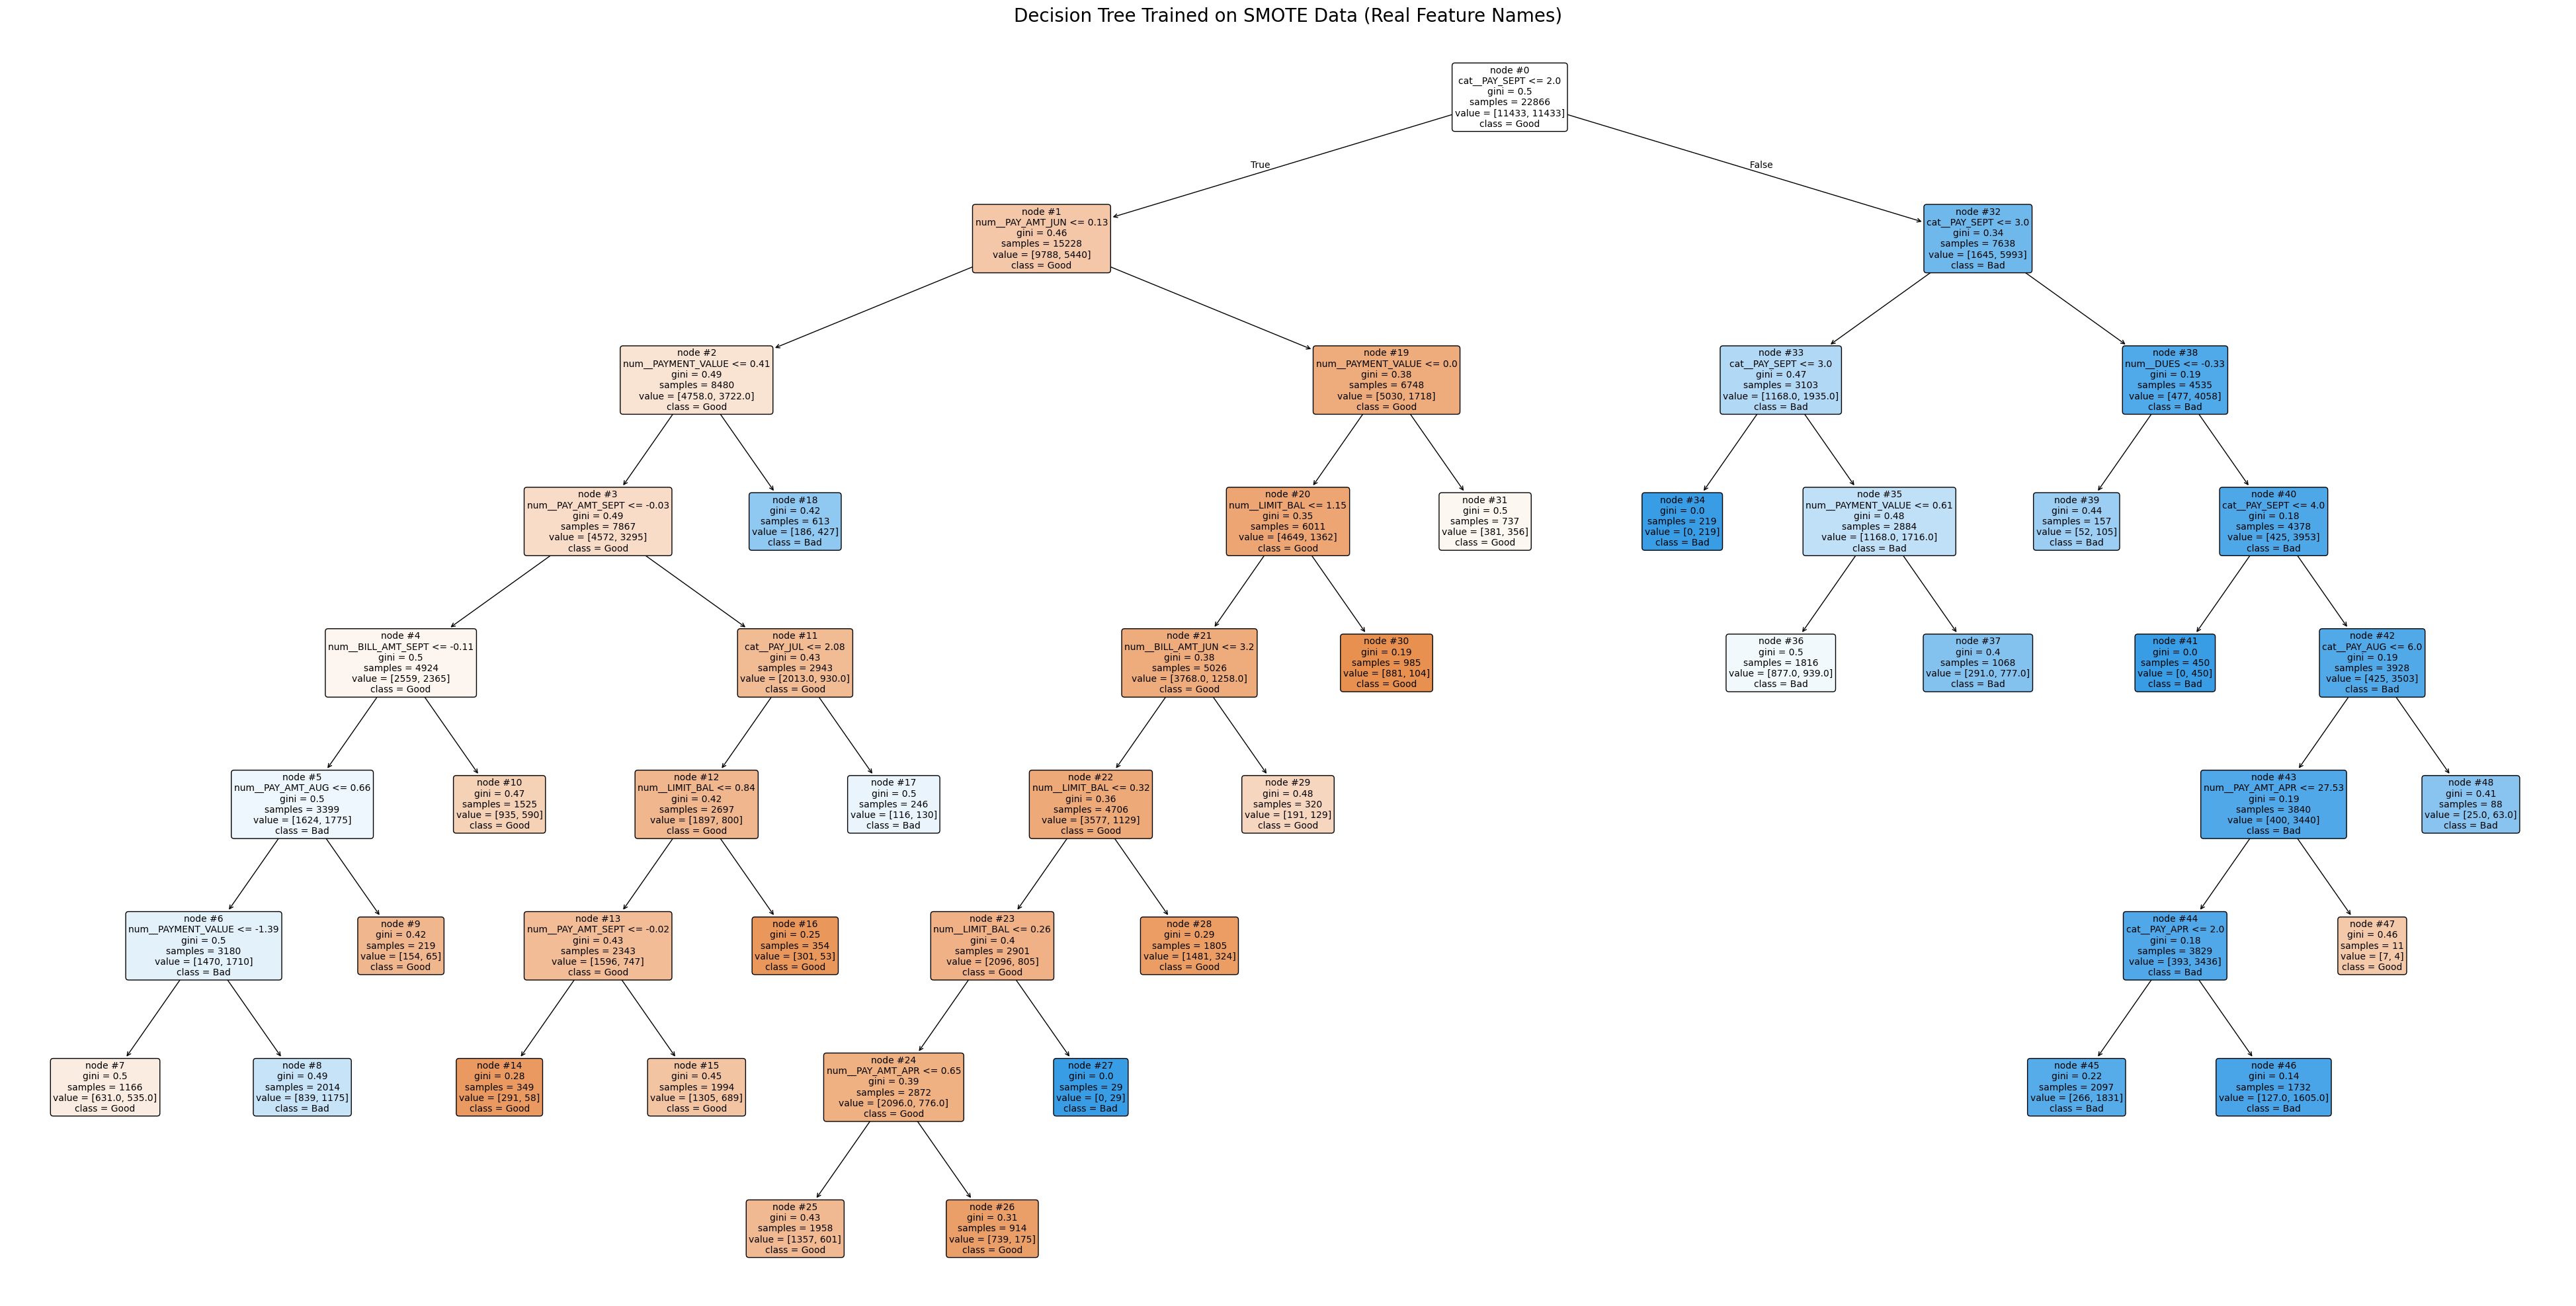

In [51]:
# 1. Try to get feature names after preprocessing
try:
    # If prep is a ColumnTransformer
    feature_names = prep.get_feature_names_out()
except AttributeError:
    # If not available, fallback to generic
    feature_names = [f'Feature {i}' for i in range(X_train_prep.shape[1])]
# Plot the tree
plt.figure(figsize=(50, 25))

plot_tree(
    clf,
    filled=True,
    rounded=True,
    feature_names=feature_names,
    class_names=['Good', 'Bad'],
    impurity=True,
    proportion=False,
    precision=2,
    fontsize=10,
    node_ids=True
)

plt.title('Decision Tree Trained on SMOTE Data (Real Feature Names)', fontsize=20)
plt.show()

In [52]:
# 1. Extract ALL leaf nodes from the tree
leaf_nodes = np.where(clf.tree_.children_left == clf.tree_.children_right)[0]

# 2. Define the helper function to describe the path to a leaf
def describe_leaf_path(clf, feature_names, leaf_id):
    path_steps = []
    node = 0  # Start at root
    while node not in leaf_nodes:
        feature = feature_names[clf.tree_.feature[node]]
        threshold = clf.tree_.threshold[node]
        if leaf_id in find_subtree_nodes(clf, clf.tree_.children_left[node]):
            decision = f"{feature} <= {threshold:.3f}"
            node = clf.tree_.children_left[node]
        else:
            decision = f"{feature} > {threshold:.3f}"
            node = clf.tree_.children_right[node]
        path_steps.append(decision)
    return path_steps

# 3. Helper to find nodes under a subtree
def find_subtree_nodes(clf, node_id):
    if clf.tree_.children_left[node_id] == clf.tree_.children_right[node_id]:  # Leaf node
        return {node_id}
    else:
        return (find_subtree_nodes(clf, clf.tree_.children_left[node_id]) |
                find_subtree_nodes(clf, clf.tree_.children_right[node_id]))

# 4. Get feature names properly
try:
    feature_names = prep.get_feature_names_out()
except AttributeError:
    feature_names = [f'Feature {i}' for i in range(X_train_prep.shape[1])]

# 5. Build the Description Table
leaf_paths = []
for leaf_id in leaf_nodes:
    path_steps = describe_leaf_path(clf, feature_names, leaf_id)
    description = " | ".join(path_steps)
    leaf_paths.append({'Leaf': leaf_id, 'Path_Description': description})

description_table = pd.DataFrame(leaf_paths)

# 6. Export the Description Table only
description_table.to_csv('leaf_only_description_table.csv', index=False)

print('✅ Leaf Description Table exported to: leaf_only_description_table.csv')


✅ Leaf Description Table exported to: leaf_only_description_table.csv


###7.7 Random Forest Scorecard

####Strengths:
Monotonicity:
Bad rate gets improved sequentially across score intervals for Train, Validation, and Test sets. This indicates good ranking risk levels by the model.

Stability:
Patterns between bad rate between training, validation, and test sets closely mirror each other, suggesting good generalization from the model with negligible overfitting.

Rejectable Segment Identification
After the 19th range (~top 15% risk population), the bad rates increase steeply, enabling a steep cutoff to reject high-risk customers at the cost of less than 15% of the portfolio.

Smooth segmentation:
Very low "irregularities" (bad rate inversions or reductions) between ranges.

####Weaknesses:
Decreased discrimination in low-risk ranges:
Early ranges (R1–R10) see bad rates transition smoothly (~8–14%), so the segmentation is weaker at the best risk levels.

Moderately higher balances in bad accounts
The bad rate on balance is 13.73% vs 15.81% on customers — i.e., bad customers slightly larger exposures.

Less "aggressive" cutoff:
Optimum cut for tough credit policy (risk increase-based) is achieved only near R18–R19 (~14.5%-15.8% bad rate), which modestly restricts early rejection.

Dataset  Lower Prob  Upper Prob  Number of Goods  Number of Bads  \
Range 1    Train    0.150144    0.217832              650              18   
Range 2    Train    0.217832    0.238937              642              25   
Range 3    Train    0.238937    0.248332              624              43   
Range 4    Train    0.248332    0.256734              617              51   
Range 5    Train    0.256734    0.269094              603              64   
Range 6    Train    0.269094    0.281173              603              64   
Range 7    Train    0.281173    0.295075              592              76   
Range 8    Train    0.295075    0.313325              592              75   
Range 9    Train    0.313325    0.331540              592              75   
Range 10   Train    0.331540    0.355363              581              87   
Range 11   Train    0.355363    0.379239              588              79   
Range 12   Train    0.379239    0.404479              571              96   
Range 13   Train    0.404479    0.428665              567             101   
Range 14   Train    0.428665    0.456575              553             114   
Range 15   Train    0.456575    0.481853              527             140   
Range 16   Train    0.481853    0.511248              501             168   
Range 17   Train    0.511248    0.542951              513             153   
Range 18   Train    0.542951    0.602209              434             233   
Range 19   Train    0.602209    0.697355              397             271   
Range 20   Train    0.697355    0.774273              308             359   
Range 21   Train    0.774273    0.853849              232             435   
Range 22   Train    0.853849    0.907706              146             522   
TOTAL      TOTAL         NaN         NaN            11433            3249   

          Total Amount  Sum Limit Goods  Sum Limit Bads  \
Range 1            668        256340000         7060000   
Range 2            667        201790000         8720000   
Range 3            667        151360000        11010000   
Range 4            668        121580000        11060000   
Range 5            667        116010000        12820000   
Range 6            667        118130000        12210000   
Range 7            668        101000000        12040000   
Range 8            667         97850000        11070000   
Range 9            667         85600000        10620000   
Range 10           668         78730000        10210000   
Range 11           667         80370000        11710000   
Range 12           667         86030000        12210000   
Range 13           668         73360000        13250000   
Range 14           667         71566000        15930000   
Range 15           667         68210000        16850000   
Range 16           669         92050000        33410000   
Range 17           666         72640000        21810000   
Range 18           667         63190000        33920000   
Range 19           668         45000000        26050000   
Range 20           667         27380000        41720000   
Range 21           667         18356000        36740000   
Range 22           668         12510000        51490000   
TOTAL            14682       2039052000       421910000   

         Relative Total Percentage Bad Rate Bad Rate Acum % of Total Acum  \
Range 1                      4.55%    2.69%         2.69%           4.55%   
Range 2                      4.54%    3.75%         3.22%           9.09%   
Range 3                      4.54%    6.45%          4.3%          13.63%   
Range 4                      4.55%    7.63%         5.13%           18.2%   
Range 5                      4.54%     9.6%         6.02%          22.71%   
Range 6                      4.54%     9.6%         6.62%          27.26%   
Range 7                      4.55%   11.38%          7.3%          31.85%   
Range 8                      4.54%   11.24%         7.79%          36.34%   
Range 9                      4.54%   11.24%       

Dataset  Lower Prob  Upper Prob  Number of Goods  Number of Bads  \
Range 1   Validation    0.150144    0.217832              227               7   
Range 2   Validation    0.217832    0.238937              290              23   
Range 3   Validation    0.238937    0.248332              259              18   
Range 4   Validation    0.248332    0.256734              274              21   
Range 5   Validation    0.256734    0.269094              288              23   
Range 6   Validation    0.269094    0.281173              230              31   
Range 7   Validation    0.281173    0.295075              258              23   
Range 8   Validation    0.295075    0.313325              263              38   
Range 9   Validation    0.313325    0.331540              238              25   
Range 10  Validation    0.331540    0.355363              271              36   
Range 11  Validation    0.355363    0.379239              247              37   
Range 12  Validation    0.379239    0.404479              226              36   
Range 13  Validation    0.404479    0.428665              221              56   
Range 14  Validation    0.428665    0.456575              250              53   
Range 15  Validation    0.456575    0.481853              233              56   
Range 16  Validation    0.481853    0.511248              232              84   
Range 17  Validation    0.511248    0.542951              234              62   
Range 18  Validation    0.542951    0.602209              196             105   
Range 19  Validation    0.602209    0.697355              170             112   
Range 20  Validation    0.697355    0.774273              132             155   
Range 21  Validation    0.774273    0.853849               94             210   
Range 22  Validation    0.853849    0.907706               68             181   
TOTAL          TOTAL         NaN         NaN             4901            1392   

          Total Amount  Sum Limit Goods  Sum Limit Bads  \
Range 1            234         88650000         2950000   
Range 2            313         91740000         7930000   
Range 3            277         58920000         4190000   
Range 4            295         53870000         4890000   
Range 5            311         59520000         4630000   
Range 6            261         43630000         5850000   
Range 7            281         44860000         3327680   
Range 8            301         44920000         5510000   
Range 9            263         33670000         2930000   
Range 10           307         36960000         4410000   
Range 11           284         37110000         4980000   
Range 12           262         36060000         5630000   
Range 13           277         28090000         8000000   
Range 14           303         30650000         5760000   
Range 15           289         31610000         6810000   
Range 16           316         42390000        16220000   
Range 17           296         32440000         7720000   
Range 18           301         28430000        16510000   
Range 19           282         19920000        11850000   
Range 20           287         12600000        16460000   
Range 21           304          6800000        18100000   
Range 22           249          5980000        17380000   
TOTAL             6293        868820000       182037680   

         Relative Total Percentage Bad Rate Bad Rate Acum % of Total Acum  \
Range 1                      3.72%    2.99%         2.99%           3.72%   
Range 2                      4.97%    7.35%         5.48%           9.95%   
Range 3                       4.4%     6.5%         5.83%          13.21%   
Range 4                      4.69%    7.12%         6.17%          18.75%   
Range 5                      4.94%     7.4%         6.43%          24.71%   
Range 6                      4.15%   11.88%         7.27%          24.88%   
Range 7                      4.47%    8.19%          7.4%          31.26%   
Range 8                      4.78% 

Dataset  Lower Prob  Upper Prob  Number of Goods  Number of Bads  \
Range 1     Test    0.150144    0.217832              372              15   
Range 2     Test    0.217832    0.238937              356              32   
Range 3     Test    0.238937    0.248332              353              23   
Range 4     Test    0.248332    0.256734              330              39   
Range 5     Test    0.256734    0.269094              454              49   
Range 6     Test    0.269094    0.281173              363              39   
Range 7     Test    0.281173    0.295075              328              50   
Range 8     Test    0.295075    0.313325              374              49   
Range 9     Test    0.313325    0.331540              359              49   
Range 10    Test    0.331540    0.355363              358              56   
Range 11    Test    0.355363    0.379239              337              44   
Range 12    Test    0.379239    0.404479              373              46   
Range 13    Test    0.404479    0.428665              336              68   
Range 14    Test    0.428665    0.456575              341              75   
Range 15    Test    0.456575    0.481853              354              80   
Range 16    Test    0.481853    0.511248              325              83   
Range 17    Test    0.511248    0.542951              334             105   
Range 18    Test    0.542951    0.602209              288             150   
Range 19    Test    0.602209    0.697355              243             164   
Range 20    Test    0.697355    0.774273              195             215   
Range 21    Test    0.774273    0.853849              142             247   
Range 22    Test    0.853849    0.907706               86             311   
TOTAL      TOTAL         NaN         NaN             7001            1989   

          Total Amount  Sum Limit Goods  Sum Limit Bads  \
Range 1            387        148920000         6150000   
Range 2            388        108610000         9180000   
Range 3            376         83840000         6230000   
Range 4            369         67820000         8380000   
Range 5            503         93930000        10140000   
Range 6            402         72670000         7690000   
Range 7            378         55360000         7020000   
Range 8            423         58720000         5870000   
Range 9            408         54220000         6110000   
Range 10           414         49810000         7390000   
Range 11           381         53380000         5400000   
Range 12           419         60950000         7400000   
Range 13           404         43970000         8950000   
Range 14           416         43640000        10380000   
Range 15           434         45330000         8290000   
Range 16           408         57410000        16720000   
Range 17           439         41570000        14370000   
Range 18           438         42740000        22480000   
Range 19           407         27410000        15470000   
Range 20           410         19600000        26140000   
Range 21           389         10140000        18720000   
Range 22           397          7690000        29370000   
TOTAL             8990       1247730000       257850000   

         Relative Total Percentage Bad Rate Bad Rate Acum % of Total Acum  \
Range 1                       4.3%    3.88%         3.88%            4.3%   
Range 2                      4.32%    8.25%         6.06%           8.63%   
Range 3                      4.18%    6.12%         6.08%          12.55%   
Range 4                       4.1%   10.57%         7.17%          16.42%   
Range 5                       5.6%    9.74%         7.81%          27.98%   
Range 6                      4.47%     9.7%         8.12%          26.83%   
Range 7                       4.2%   13.23%         8.81%          29.43%   
Range 8                      4.71%   11.58%         9.18%          37.64%   
Range 9                      4.54%   12.01%       

✅ Random Forest fixed range tables exported!


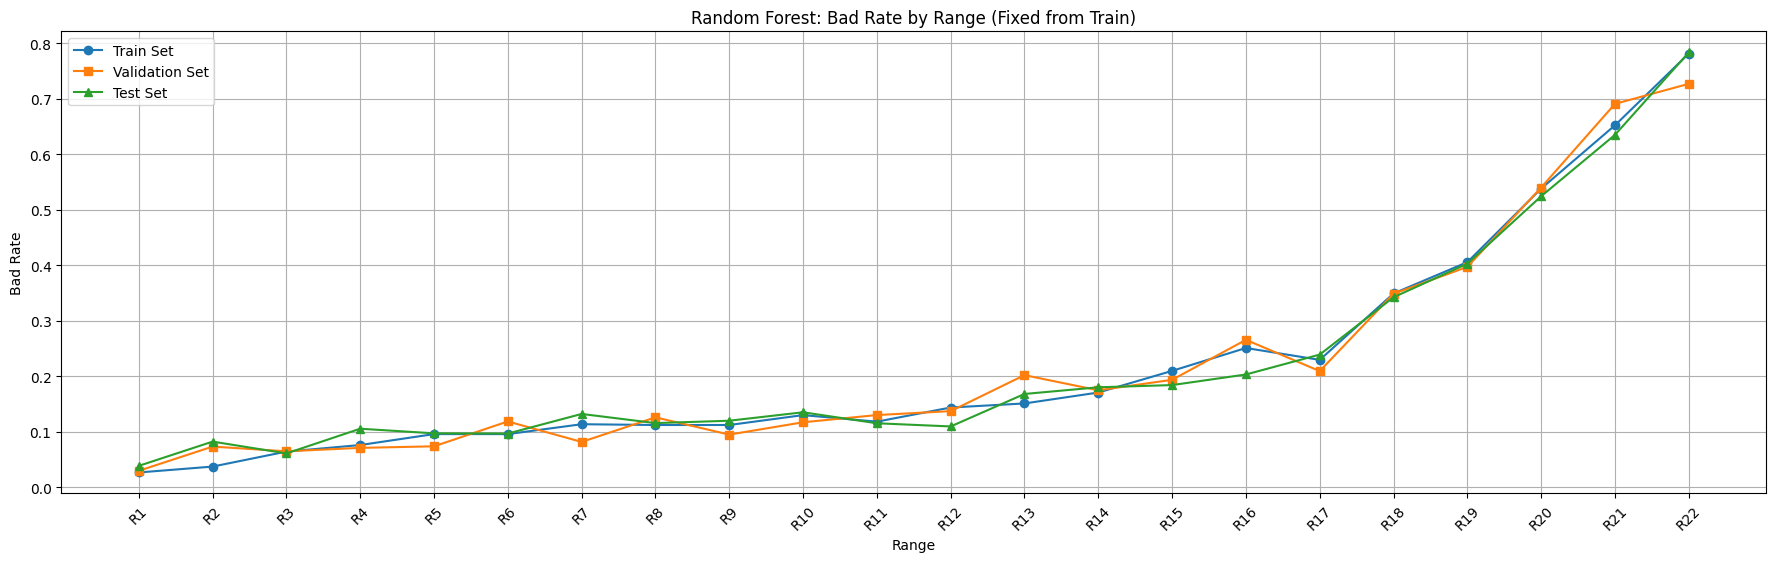

In [54]:
# 1. Predict probabilities for Train, Val, Test
train_probs_rf = best_rf.predict_proba(X_train)[:, 1]
val_probs_rf = best_rf.predict_proba(X_val)[:, 1]
test_probs_rf = best_rf.predict_proba(X_test)[:, 1]

ranges = 22

# 2. Generate bins using Train only
train_df_rf = pd.DataFrame({
    'prob': train_probs_rf,
    'target': y_train.reset_index(drop=True),
    'LIMIT_BAL': X_train['LIMIT_BAL'].reset_index(drop=True)
})
train_df_rf['range'], bins_rf = pd.qcut(train_df_rf['prob'], q=ranges, retbins=True, labels=False, duplicates='drop')

# 3. Define function with fixed bins
def create_rf_fixed_range_table(probs, targets, limit_balances, dataset_name, bins):
    df = pd.DataFrame({
        'prob': probs,
        'target': targets.reset_index(drop=True),
        'LIMIT_BAL': limit_balances.reset_index(drop=True)
    })
    df['range'] = pd.cut(df['prob'], bins=bins, labels=False, include_lowest=True)

    table = []
    total_records = len(df)
    total_bads = (df['target'] == 1).sum()
    total_goods = (df['target'] == 0).sum()

    cumulative_bads = 0
    cumulative_goods = 0

    for bin_num in sorted(df['range'].dropna().unique()):
        subset = df[df['range'] == bin_num]
        lower_prob = bins[bin_num]
        upper_prob = bins[bin_num + 1]
        number_goods = (subset['target'] == 0).sum()
        number_bads = (subset['target'] == 1).sum()
        total_amount = number_goods + number_bads
        relative_percentage = total_amount / total_records
        bad_rate = number_bads / total_amount if total_amount > 0 else 0

        cumulative_bads += number_bads
        cumulative_goods += number_goods

        sum_limit_goods = subset[subset['target'] == 0]['LIMIT_BAL'].sum()
        sum_limit_bads = subset[subset['target'] == 1]['LIMIT_BAL'].sum()

        table.append({
            'Dataset': dataset_name,
            'Lower Prob': lower_prob,
            'Upper Prob': upper_prob,
            'Number of Goods': number_goods,
            'Number of Bads': number_bads,
            'Total Amount': total_amount,
            'Sum Limit Goods': int(sum_limit_goods),
            'Sum Limit Bads': int(sum_limit_bads),
            'Relative Total Percentage': relative_percentage,
            'Bad Rate': bad_rate,
            'Bad Rate Acum': cumulative_bads / (cumulative_bads + cumulative_goods) if (cumulative_bads + cumulative_goods) > 0 else 0,
            '% of Total Acum': (total_amount * (bin_num+1)) / total_records,
            '% of Bads Acum': cumulative_bads / total_bads if total_bads > 0 else 0,
            '% of Goods Acum': cumulative_goods / total_goods if total_goods > 0 else 0
        })

    result_table = pd.DataFrame(table)
    result_table.index = [f'Range {i+1}' for i in range(len(result_table))]

    # Format ONLY percentages
    percent_cols = ['Relative Total Percentage', 'Bad Rate', 'Bad Rate Acum',
                    '% of Total Acum', '% of Bads Acum', '% of Goods Acum']
    for col in percent_cols:
        result_table[col] = (result_table[col].astype(float) * 100).round(2).astype(str) + '%'

    # Add TOTAL row
    total_row = pd.DataFrame({
        'Dataset': ['TOTAL'],
        'Lower Prob': [None],
        'Upper Prob': [None],
        'Number of Goods': [result_table['Number of Goods'].astype(int).sum()],
        'Number of Bads': [result_table['Number of Bads'].astype(int).sum()],
        'Total Amount': [result_table['Total Amount'].astype(int).sum()],
        'Sum Limit Goods': [result_table['Sum Limit Goods'].astype(int).sum()],
        'Sum Limit Bads': [result_table['Sum Limit Bads'].astype(int).sum()],
        'Relative Total Percentage': [''],
        'Bad Rate': [result_table['Bad Rate Acum'].iloc[-1]],
        'Bad Rate Acum': [''],
        '% of Total Acum': [''],
        '% of Bads Acum': [''],
        '% of Goods Acum': ['']
    }, index=['TOTAL'])

    result_table = pd.concat([result_table, total_row])

    display(result_table)
    return result_table

# 4. Create tables (with fixed bins!)
train_table_rf = create_rf_fixed_range_table(train_probs_rf, y_train, X_train['LIMIT_BAL'], 'Train', bins_rf)
val_table_rf = create_rf_fixed_range_table(val_probs_rf, y_val, X_val['LIMIT_BAL'], 'Validation', bins_rf)
test_table_rf = create_rf_fixed_range_table(test_probs_rf, y_test, X_test['LIMIT_BAL'], 'Test', bins_rf)

# 5. Save to CSV
train_table_rf.to_csv('rf_train_ranges_table_fixed.csv', index=False)
val_table_rf.to_csv('rf_val_ranges_table_fixed.csv', index=False)
test_table_rf.to_csv('rf_test_ranges_table_fixed.csv', index=False)
print('✅ Random Forest fixed range tables exported!')

# 6. Plot Bad Rates
plt.figure(figsize=(ranges, 6))

train_plot = train_table_rf.drop('TOTAL')
val_plot = val_table_rf.drop('TOTAL')
test_plot = test_table_rf.drop('TOTAL')

train_bad_rate = train_plot['Bad Rate'].str.rstrip('%').astype(float) / 100
val_bad_rate = val_plot['Bad Rate'].str.rstrip('%').astype(float) / 100
test_bad_rate = test_plot['Bad Rate'].str.rstrip('%').astype(float) / 100

plt.plot(train_bad_rate, label='Train Set', marker='o')
plt.plot(val_bad_rate, label='Validation Set', marker='s')
plt.plot(test_bad_rate, label='Test Set', marker='^')

plt.title('Random Forest: Bad Rate by Range (Fixed from Train)')
plt.xlabel('Range')
plt.ylabel('Bad Rate')
plt.xticks(ticks=range(ranges), labels=[f'R{i+1}' for i in range(ranges)], rotation=45)
plt.legend()
plt.grid(True)
plt.show()


###7.7 Table Summary

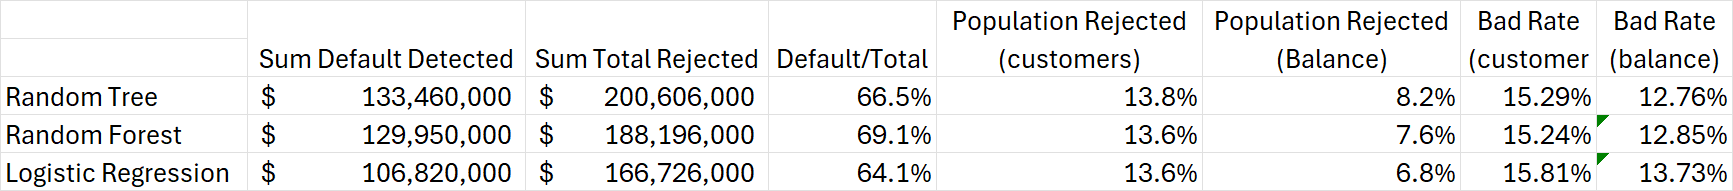

## 8. Statistical Testing

### 8.1 Mann-Whitney U test

This directly answers our research question about whether credit limits
differ significantly between defaulters and non-defaulters.

In [55]:
from scipy.stats import mannwhitneyu
u, p = mannwhitneyu(X_test[y_test==0]['LIMIT_BAL'],
                   X_test[y_test==1]['LIMIT_BAL'],
                   alternative='two-sided')
print(f"Mann-Whitney U test on LIMIT_BAL between defaulters and non-defaulters:")
print(f"U={u}, p={p:.6e}")
if p < 0.05:
    print("CONCLUSION: There is a statistically significant difference in credit limits between defaulters and non-defaulters.")
    print("This supports our hypothesis that credit limit policies should be adjusted based on risk factors.")
else:
    print("CONCLUSION: No significant difference found in credit limits between defaulters and non-defaulters.")


Mann-Whitney U test on LIMIT_BAL between defaulters and non-defaulters:
U=8638836.0, p=1.116843e-60
CONCLUSION: There is a statistically significant difference in credit limits between defaulters and non-defaulters.
This supports our hypothesis that credit limit policies should be adjusted based on risk factors.


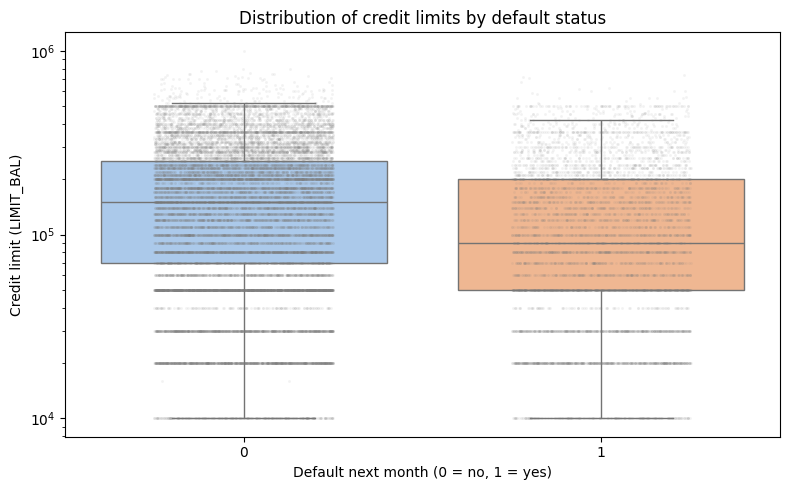

In [56]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=original_df,
            x='PAYMENT_DEFAULT', y='LIMIT_BAL',
            palette='pastel',
            showfliers=False)

sns.stripplot(data=original_df,
              x='PAYMENT_DEFAULT', y='LIMIT_BAL',
              color='grey', alpha=0.1, jitter=0.25, size=2)

plt.yscale('log')
plt.xlabel('Default next month (0 = no, 1 = yes)')
plt.ylabel('Credit limit (LIMIT_BAL)')
plt.title('Distribution of credit limits by default status')
plt.tight_layout()
plt.show()

### 8.1 Mann-Whitney insights


- The p‑value is far below 0.05; we reject the null hypothesis. The distribution of credit limits (LIMIT_BAL) differs significantly between customers who defaulted and those who did not.
-  Non‑defaulters tend to hold higher credit limits. This supports the proposal to incorporate LIMIT_BAL into risk‑based policy rules (e.g., lower initial limits for high‑risk applicants, incremental increases tied to on‑time payment history).

## 9. Insights and Conclusions

### 9.1 Summarize key findings

####Statistical Analysis
A Mann-Whitney U test was performed to determine whether there is a difference in the distribution of LIMIT_BAL between defaulters and non-defaulters.

Result: U=8,638,836.0, p=1.116843e-60

Conclusion: There is a statistically significant difference in credit limits between the two groups. This validates our hypothesis that the adjustment of credit limits according to estimated default risk would make the credit policy more robust.

####Model Evaluation Insights

#####Decision Tree

* Achieved ~72% accuracy on test data with consistent train-validation performance.

* Hyperparameters favored a more profound tree (depth=20) and split threshold of less (0.1).

* 0.50 F1 score and 63.2% recall on the test set reflect good ability to flag defaulters.

* Provides understandable rules for policy enforcement, though depth requires business trimming with care.

#####Logistic Regression

* 72.2% on test data with closely comparable Decision Tree performance.

* Showed strong recall (62.3%) and consistent performance on training, validation, and test sets.

* 41.5% precision shows moderate conservativeness in rejecting, with equilibrium between false positives and false rejections.

* Regularization strength (C=10) suggests keeping important variables with minimal penalty.

* Best suited for a policy that should exhibit steady, robust performance across many datasets.

#####Random Forest

* Overall best performance, 75.3% accuracy and AUC 0.766 on test data.

* Highest F1 score (0.530), good equilibrium between precision (45.7%) and recall (62.9%).

* Hyperparameters were tree depth of 5 and an ensemble size of 100 trees.

* Resists instability over datasets, minimizing risk of overfitting.

* Works best at capturing complex, nonlinear relations while being tractable to interpret.


### 9.2 Discuss model performance and business impact

####Credit Loss and Risk Quantification

Comparison of policy performance between models (by defaults identified and exposure rejected):

* Random Tree identifies the highest dollar value of defaults ($133.5M), but with a slightly higher cost of rejection.

* Random Forest is most efficient: best bad capture as a percentage of balance rejected (69.1% Default/Total), lowest unnecessary customer loss (only 13.6% customers rejected, and 7.6% balance rejected).

* Logistic Regression has the highest bad rate for defaulted customers (15.81%), but indicates fewer total defaults ($106.8M) and therefore adopts a more active but less sensitive approach.

####Strategic Analysis

* Random Forest would be the best model for implementing the credit policy into action because of its best trade-off between risk reduction and customer retention.

* Decision Tree can be used for producing comprehensible policy rules, thus preserving business meaning and simplicity of compliance, as long as it is hand-in-hand with pruning policies.

* Logistic Regression is stable and has strong generalization and is thus suitable for secondary risk monitoring or policy layers in complement.

All three models have strong AUC (0.73–0.77), with proof of stable discriminative ability and validation of the predictive power of the selected features.

####Recommendation

Based on the assessment of predictive performance, business goals, and operational viability, it is suggested to use the *Random Forest model* for the new credit policy.

Rationale:

* Optimal Predictive Power: Random Forest had the best accuracy (75.3%) and F1 score (0.530) among all models, providing a good balance between identifying true defaulters (recall 62.9%) and having acceptable false positives (precision 45.7%).

* Optimal Business Tradeoff: It acquires 69.1% of default dollars at a loss of just 13.6% of customers with a comparatively low balance rejection ratio of 7.6%, optimizing profitability at minimum customer loss.

* Stability Across Datasets: Random Forest has uniform performance on the training, validation, and test sets, indicating strong generalization to new customers with minimal chances of severe overfitting.

* Credit Loss Reduction: Random Forest offers a significant decrease in possible losses through the exclusion of high-risk clients with the least business disruption compared to the Decision Tree or the Logistic Regression.

### 9.3 Answer research questions

1. Is there a statistically significant difference in credit limit (LIMIT_BAL) between defaulters and non-defaulters?
* Yes. The results of the Mann-Whitney U test (U = 8,638,836.0, p = 1.116843e-60) show that there is a very highly statistically significant difference in credit limits between defaulters and non-defaulters.
This finding supports the hypothesis that credit limits need to be adjusted based on customer risk factors, and validates the need to include LIMIT_BAL in the prediction models and credit policy formulation.

2. Which predictive model performs best for credit risk estimation and policy setting?
* Random Forest model works best. It worked with the highest accuracy (75.3%) and F1 score (0.530) among all models. It possesses a balanced precision (45.7%) and recall (62.9%), which means it is effective in capturing defaulters without rejecting too many good customers. It captures 69.1% of default dollars at a customer population rejection rate of just 13.6%. Random Forest, thus, is the best model for achieving maximum credit loss reduction with minimum customer base impact.

3. Can we achieve a meaningful reduction in credit losses without rejecting a large portion of customers?
* Yes. All models achieved bad rate reductions of poor quality by rejecting approximately 13.6%-13.8% of customers, which is well within the business threshold of less than 15% rejection.
* Random Forest rejects 13.6% of customers and deletes 7.6% of the balance while capturing 69.1% of the default amount. What this implies is that smart, risk-based strategies of rejection can significantly reduce losses without having much impact on customer acquisition or portfolio size.

4. How much default risk (bad rate) reduction can be achieved through different model-driven strategies?
* Significant reduction is achievable. Random Tree decreases bad rates (customer view) from around ~10% baseline to 15.29% after removing the bottom segment. Random Forest also decreases to 15.24%, slightly better handling the risk than rejected balances. Logistic Regression achieves a low rate of 15.81%, but at the cost of marginally lower default dollars captured over Random Forest.
There is a clear portfolio quality increase across all models, with support for the resilience of model-based strategies against risk management.

### 9.4 Identify limitations and potential improvements

####Limitations

* Data Scope:
The data highlights demographic and monetary characteristics but does not include behavioral information (like payment behavior dynamics, transaction history), which would make the model less capable of identifying actual determinants of risk in real-time.

* Model Complexity vs. Interpretability:
While Random Forest was best at prediction, it sacrifices some interpretability and it is harder to translate directly into straightforward business rules from its output compared to Decision Trees.
The models use fixed customer rejection thresholds, which are not necessarily optimized to current economic conditions or customer profiles over time.

* Static Analysis:
The analysis makes static credit behavior assumptions. Customer risk levels may vary with macroeconomic changes, but the current models do not dynamically adapt unless retrained periodically.
The current models also handle false positives (good customers mistakenly rejected) and false negatives (bad customers accepted) in the same manner, even though their business implications are quite distinct.

* Imbalanced Dataset Risk:
Despite the tolerable bad rate (~22%), class imbalance remains. Advanced sampling techniques like SMOTE were not explored, which might further boost minority class identification.

####Potential Improvements

* Behavioral Feature Enrichment
Add other variables like recent spending increases, payments overdue, or cash advance rate to improve warning potential in an early phase.

* Model Monitoring and Recalibration:
Implement continuous performance monitoring and recalibration pipelines to adjust thresholds and model weights as portfolio or economic conditions evolve.

* Cost-Sensitive Modeling:
Activate cost-sensitive learning paradigms that are tailored to systematically penalize misclassification on financial loss severity so that model optimization is more aligned with business goals.

* Hybrid Modeling Approaches
Experiment integrating Logistic Regression (for transparency) and Random Forest (for precision) using model stacking or blending methodologies to attain the right level of accuracy as well as interpretability.

* Explainable AI Tools:
Implement SHAP (SHapley Additive exPlanations) values or LIME (Local Interpretable Model-agnostic Explanations) to clarify sophisticated model output better for business stakeholders and regulators.

* Dynamic Credit Limit Adjustments:
Escape the dual acceptance/rejection. Establish active limit adjustment policies based on estimated risk, extending lower limits to marginal applicants instead of outright rejection.